In [1]:
# Kaggle
# https://www.kaggle.com/docstein/brics-world-bank-indicators
# https://www.kaggle.com/worldbank/world-development-indicators?select=Indicators.csv

# Resources
# https://datahelpdesk.worldbank.org/knowledgebase/articles/906531-methodologies

# Group members and their contributions

# Abstract

# Introduction

# Setup and configuration

In [1]:
!pip install dtaidistance
!pip install pyclustering

import os
import zipfile
import warnings
import numpy as np
import pandas as pd
import pyclustering
import dtaidistance
import seaborn as sns 
from fastdtw import fastdtw
from sklearn import manifold  
import matplotlib.pyplot as plt
import statsmodels.tsa.vector_ar
from statsmodels.tsa.api import VAR
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from pyclustering.cluster.kmedoids import kmedoids
from sklearn.cluster import AgglomerativeClustering
from statsmodels.tsa.vector_ar.var_model import VAR
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import euclidean, squareform
from statsmodels.tsa.stattools import adfuller, acf, pacf
from pyclustering.cluster import cluster_visualizer_multidim
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from numpy import asarray
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot


In [2]:
# todo vitalijus: describe the cofig

In [3]:
environment = 'local'

if environment == 'local':
    # prepare dataframes
    series_path = "data/Series.csv"
    country_path = "data/Country.csv"
    indicators_path = "data/Indicators.csv"
    country_notes_path = "data/CountryNotes.csv"
elif environment == 'colab':
    # imports
    from google.colab import drive
    drive.mount('/content/drive')
    # download from kaggle
    os.environ['KAGGLE_USERNAME'] = "cubicsrube" # username from the json file
    os.environ['KAGGLE_KEY'] = "6e2367734120e39c492cbf125549e6ca" # key from the json file
    !kaggle datasets download -d worldbank/world-development-indicators # api copied from kaggle
    # unzip
    with zipfile.ZipFile('/content/world-development-indicators.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    # prepare dataframes
    series_path = "/content/data/Series.csv"
    country_path = "/content/data/Country.csv"
    indicators_path = "/content/data/Indicators.csv"
    country_notes_path = "/content/data/CountryNotes.csv"
else:
    raise Exception('Set "environment" variable. Current value is "{}".'.format(environment))

series_df = pd.read_csv(series_path, sep=",")
country_df = pd.read_csv(country_path, sep=",")
indicators_df = pd.read_csv(indicators_path, sep=",")
country_notes_df = pd.read_csv(country_notes_path, sep=",")

FileNotFoundError: [Errno 2] File data/Series.csv does not exist: 'data/Series.csv'

In [4]:
indicators_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Indicators.csv", sep=",")
country_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Country.csv", sep=",")
country_notes_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\CountryNotes.csv", sep=",")
series_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Series.csv", sep=",")

In [4]:
# os.environ['KAGGLE_USERNAME'] = "cubicsrube" # username from the json file
# os.environ['KAGGLE_KEY'] = "6e2367734120e39c492cbf125549e6ca" # key from the json file
# !kaggle datasets download -d worldbank/world-development-indicators # api copied from kaggle

In [5]:
# with zipfile.ZipFile('/content/world-development-indicators.zip', 'r') as zip_ref:
#     zip_ref.extractall('/content/data/')

In [6]:
# series_df = pd.read_csv("/content/data/Series.csv", sep=",")
# country_df = pd.read_csv("/content/data/Country.csv", sep=",")
# indicators_df = pd.read_csv("/content/data/Indicators.csv", sep=",")
# country_notes_df = pd.read_csv("/content/data/CountryNotes.csv", sep=",")
#indicators_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Indicators.csv", sep=",")
#country_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Country.csv", sep=",")
#country_notes_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\CountryNotes.csv", sep=",")
#series_df = pd.read_csv(r"C:\Users\yosie\Desktop\Data Sceince\DAT 540\Series.csv", sep=",")

FILER DATA FROM COUNTRIES THAT ONLY USED THE 2008 SYSTEM OF NATIONAL ACCOUNTS METHODOLOGY

In [5]:
# Country filters ['SystemOfNationalAccounts']
# - Country uses the 1968 System of National Accounts methodology.
# - Country uses the 1993 System of National Accounts methodology.
# - Country uses the 2008 System of National Accounts methodology.
countries = country_df[country_df['SystemOfNationalAccounts']=='Country uses the 2008 System of National Accounts methodology.'].reset_index()
# 
country_codes = list(countries['CountryCode'])
# todo: drop argentina

### Data preprocessing

todo kobina: describe a thereshold on and dropping countries, removing columns etc.
todo kobina: also, docstring with description and params

Import DataFrames

In [6]:
indicators_countries =indicators_df
col_filtered = indicators_countries[["IndicatorCode","CountryCode","Year","Value"]]
years = list(col_filtered["Year"].unique())
ind_codes = list(col_filtered["IndicatorCode"].unique())
full_data = list(indicators_countries["IndicatorCode"].unique())
len(ind_codes) #determine the total number of indicators

1344

Create Function to fill all countries with all possible indicators. NA values 
will be filled in cells where indicator is not measured for the particular country that year.

In [7]:
def get_tbl_full_year(country_code,year):
  """
  Returns aasdad ...
  Parameters:
    country (str):The string which is to be reversed.
    year (int):The string which is to be reversed.
  Returns:
    reverse(str1): The string which gets reversed
  """
  #determine the unique indicators which exist for a particular country
  df2 = col_filtered[col_filtered["CountryCode"] == country_code]

  #get all indicators for a particular year
  ind_dicts = list(map(lambda x: get_ind_dict(df2,x), year))

  #create dictionary for all indicators for all years
  ind_dicts = list(map(lambda x: create_dict(x), ind_dicts))
  return (ind_dicts)

def get_ind_dict(df2,year):
  #get all the indicators measured for a particular year
  df3 = df2[df2["Year"] == year][["IndicatorCode","Value"]]
  df3.set_index("IndicatorCode",inplace=True)
  df3 =  df3.transpose()
  ind_dict = dict(df3)
  ind_dict = create_dict(ind_dict)
  return (ind_dict)
  
def create_dict(ind_dict): 
  #create dictionary pairing indicators and their readings for that year
  for key in ind_dict:
    try:
      ind_dict[key] = ind_dict[key][0]
    except (IndexError, TypeError):
      pass
  absent_bool = list(map(lambda x: x not in ind_dict, full_data))
  absent_array = np.array(full_data)[np.array(absent_bool)]
  absent_dict = {}
  for i in range(len(absent_array)):
    absent_dict.update({absent_array[i]:np.nan})
  ind_dict.update(absent_dict)
  return (ind_dict)

In [8]:
def fn(index, from_year, to_year):
  n_years = to_year - from_year
  a = get_tbl_full_year(country_codes[index], list(range(from_year, to_year)))
  a = pd.DataFrame(a)
  a.index = [np.tile(country_codes[index], to_year - from_year), np.arange(from_year, to_year, 1)]
  return a

# processed_attributes = pd.DataFrame(dict()) #fn(0, 2008, 2016)
def create_df(max_na, threshold, from_year, to_year):
  # add country codes with a maximum of max_na(fraction) NaN cells.
  processed_attributes = None
  n_years = to_year - from_year
  for i in range(0, len(country_codes)):
    temp = fn(i, from_year, to_year)
    perc = 1 - temp.applymap(lambda x: pd.isna(x)).sum().sum() / np.prod(temp.shape)
    # percentage of non_na cells
    if perc > max_na:
      print(f"Adding {country_codes[i]} {perc}")
      if processed_attributes is None:
        processed_attributes = temp
      else:
        processed_attributes = pd.concat([processed_attributes, temp], axis=0)
    else:
      print(f"Skipping {country_codes[i]} {perc}")
  processed_attributes.dropna(thresh=(threshold*len(processed_attributes.index)), axis=1, inplace=True)
  return (processed_attributes, n_years)

In [9]:
processed_attributes , n_years= create_df(0.3, 0.99, 1990,2015)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333
Adding RWA 0.5667559523809524
Adding SGP 0.4202678571428572
Adding SVK 0.46220238

OBTAIN SUMMARY OF RESULTANT DATAFRAME

In [12]:
total_values = processed_attributes.count().sum()
total_values_na = processed_attributes.applymap(lambda x: pd.isna(x)).sum().sum()
print(f"Total: {total_values + total_values_na}, Values: {total_values}, NA: {total_values_na}")

Total: 40700, Values: 40680, NA: 20


DETERMINE NUMBER OF COUNTRIES REMAINING

In [13]:
#processed_attributes.to_csv('/content/data.csv')
filtered_series = series_df[series_df['SeriesCode'].isin(processed_attributes.columns)]
#filtered_series.to_csv('/content/data.csv')
print(f"There are {len(processed_attributes.index)/n_years} countries left")

There are 44.0 countries left


GET LIST OF ALL COUNTRIES REMAINING FOR LATER USE

In [14]:
def get_country_list(processed_attributes):
  country_set = set((processed_attributes.index).map(lambda x: x[0]))
  country_list = list(country_set)
  country_list.sort()
  return country_list
country_list = get_country_list(processed_attributes)

INTERPOLATE AND IMPUTE WHERE INTERPOLATION DID NOT WORK

In [15]:
def impute(processed_attributes,index):
  df_cum = processed_attributes[(processed_attributes.index).map(lambda x: x[0] == country_list[index])]
  nan_cols = [i for i in df_cum.columns if df_cum[i].isnull().all()]
  for colname in nan_cols:
    df_cum[[colname]] = 0;
  imputed_data = df_cum.apply(lambda x:x.interpolate(method='linear'))
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', copy = True)
  imputed_data = pd.DataFrame(imp_mean.fit_transform(imputed_data))
  imputed_data.columns = df_cum.columns
  #data1 = data1.fillna(method='ffill')
  return imputed_data #pd.DataFrame(imputed_data, columns = df_cum.columns)

In [16]:
def impute_a(processed_attributes, rng):
  return list(map(lambda x: impute(processed_attributes, x),rng))
a = impute_a(processed_attributes, range(0,len(country_list)))

In [17]:
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
inds = data_scaled.columns

In [18]:
def corrmat(abs=False):
  f = plt.figure(figsize=(30, 15))
  if abs == True:
    plt.matshow(np.abs(data_scaled.corr()), fignum=f.number)
  else:
    plt.matshow(data_scaled.corr(), fignum=f.number)
  plt.xticks(range(data_scaled.shape[1]), inds, fontsize=10, rotation=90)
  plt.yticks(range(data_scaled.shape[1]), inds, fontsize=10)
  cb = plt.colorbar()
  cb.ax.tick_params(labelsize=10)

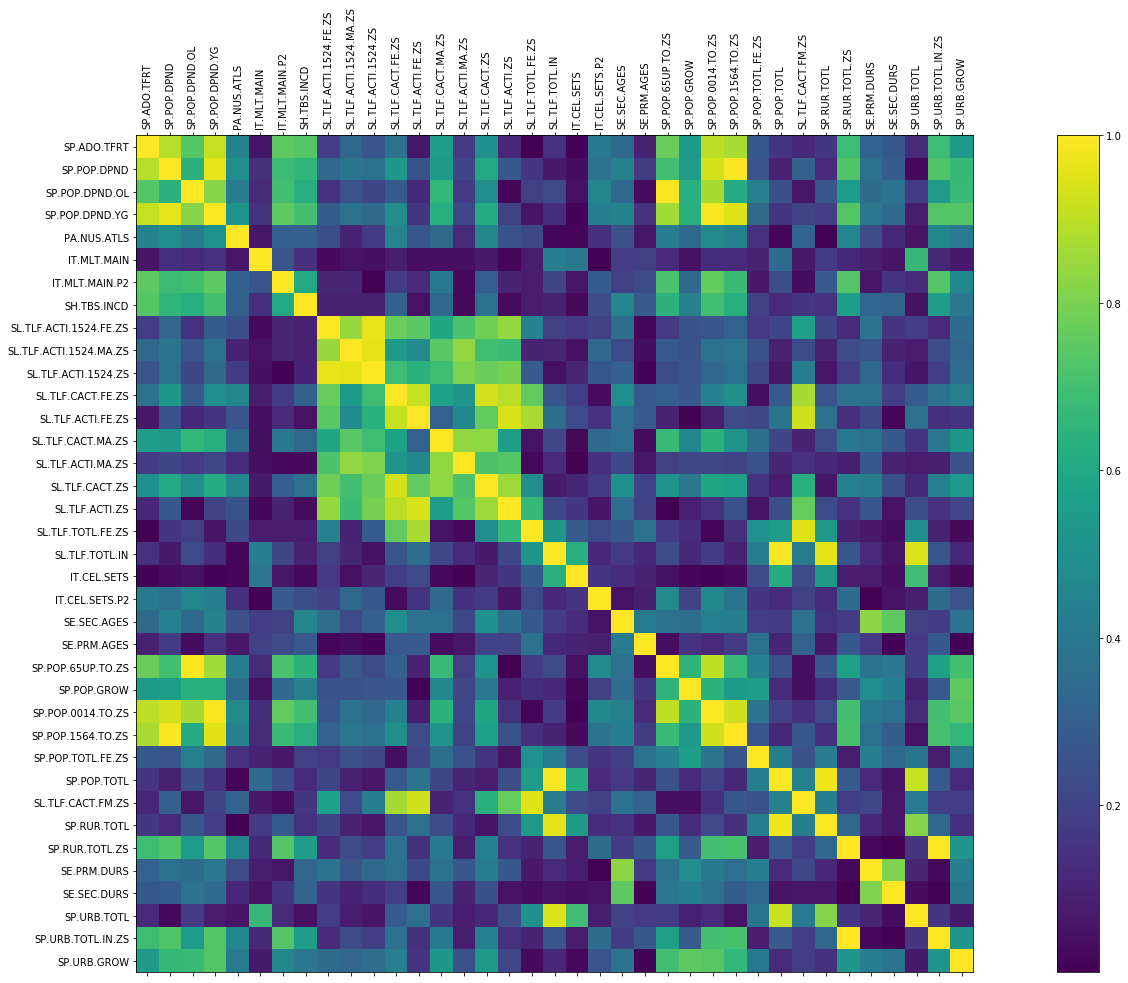

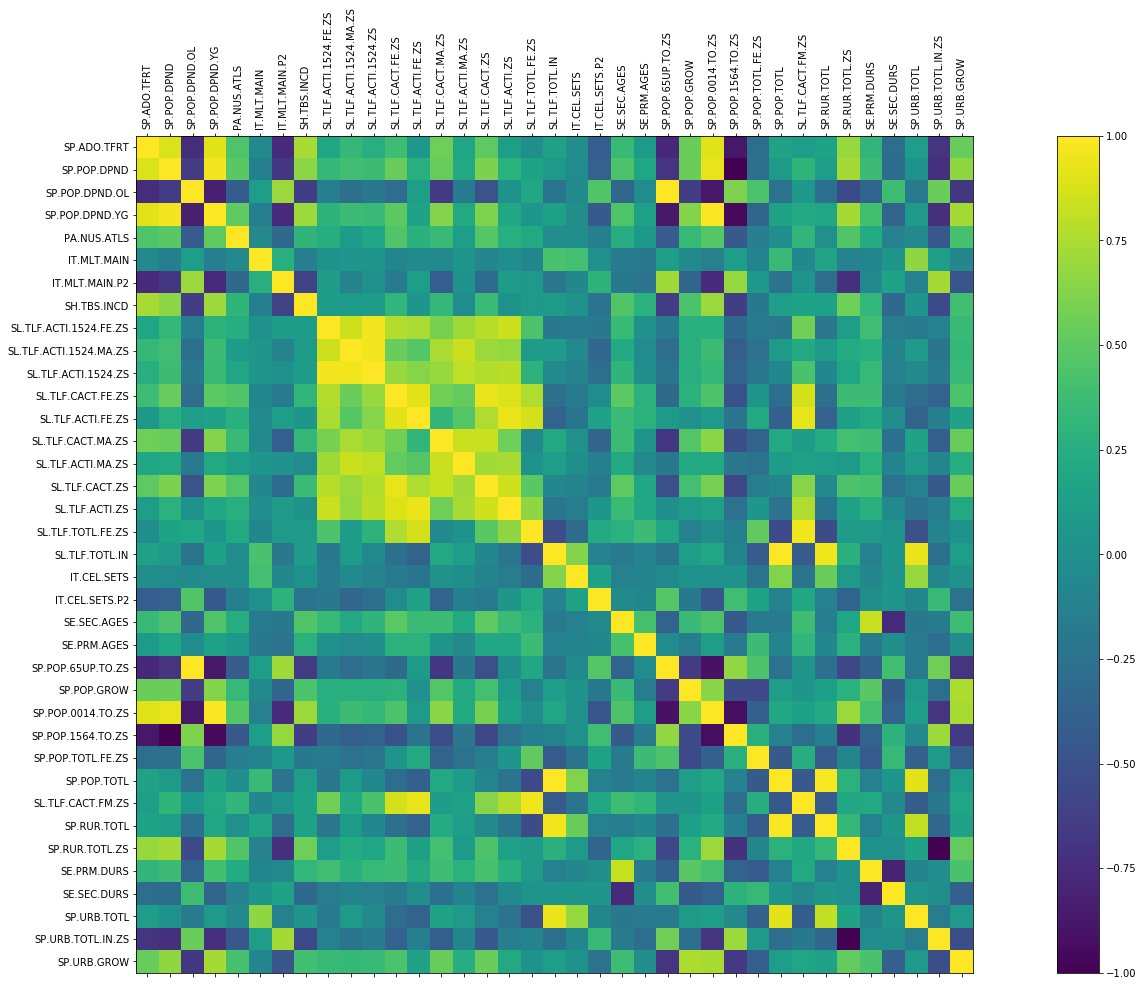

In [19]:
corrmat(abs = True);
corrmat(abs = False);

## PCA

In [20]:
# todo moses: do your thing: what it means, 
# todo moses: docstring
# todo moses: references


In [21]:
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

In [22]:
print(f"{n_years} years are under consideration")

25 years are under consideration


In [23]:
summary_df = pd.DataFrame([pcamodel.explained_variance_ , pcamodel.explained_variance_ratio_]).transpose()
summary_df.columns = ["explained_variance","explained_variance_ratio"]
summary_df

,explained_variance,explained_variance_ratio
0,13.046160,0.352278
1,7.549224,0.203848
2,4.176577,0.112778
3,2.954278,0.079773
4,1.993378,0.053826
5,1.308509,0.035333
6,1.006588,0.027180
7,0.774176,0.020905
8,0.692809,0.018708
9,0.624541,0.016864


## explained variance plot

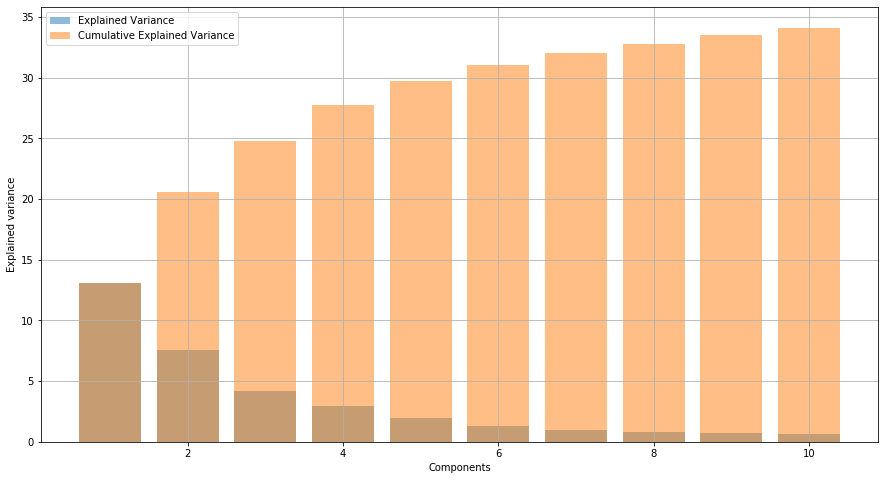

In [24]:
plt.figure(figsize=(15,8))

plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
        pcamodel.explained_variance_,
        label="Explained Variance", alpha = 0.5)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.bar(range(1,len(pcamodel.explained_variance_ )+1),
         np.cumsum(pcamodel.explained_variance_),
         label="Cumulative Explained Variance", alpha = 0.5)
plt.legend(loc='upper left')
plt.grid()

### explained variance ratio plot

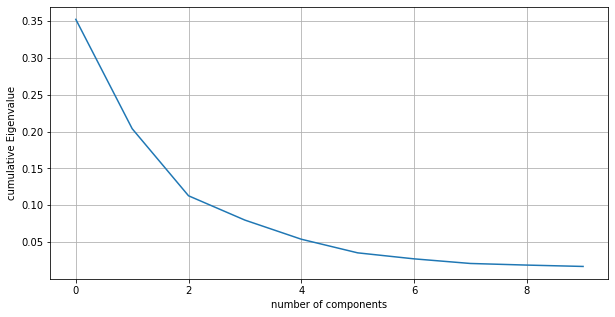

In [25]:
plt.figure(figsize=(10,5))
plt.plot(pcamodel.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative Eigenvalue')
plt.grid()
plt.show()

### scree plot

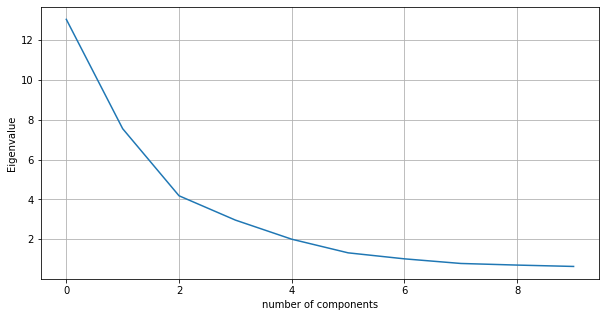

In [26]:
plt.figure(figsize=(10,5))
plt.axis
plt.plot(pcamodel.explained_variance_)
plt.xlabel('number of components',)
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [27]:
pcamodel.explained_variance_

array([13.04616037,  7.54922392,  4.17657712,  2.95427795,  1.99337796,
        1.30850867,  1.00658751,  0.77417555,  0.69280901,  0.6245406 ])

## PCA plots

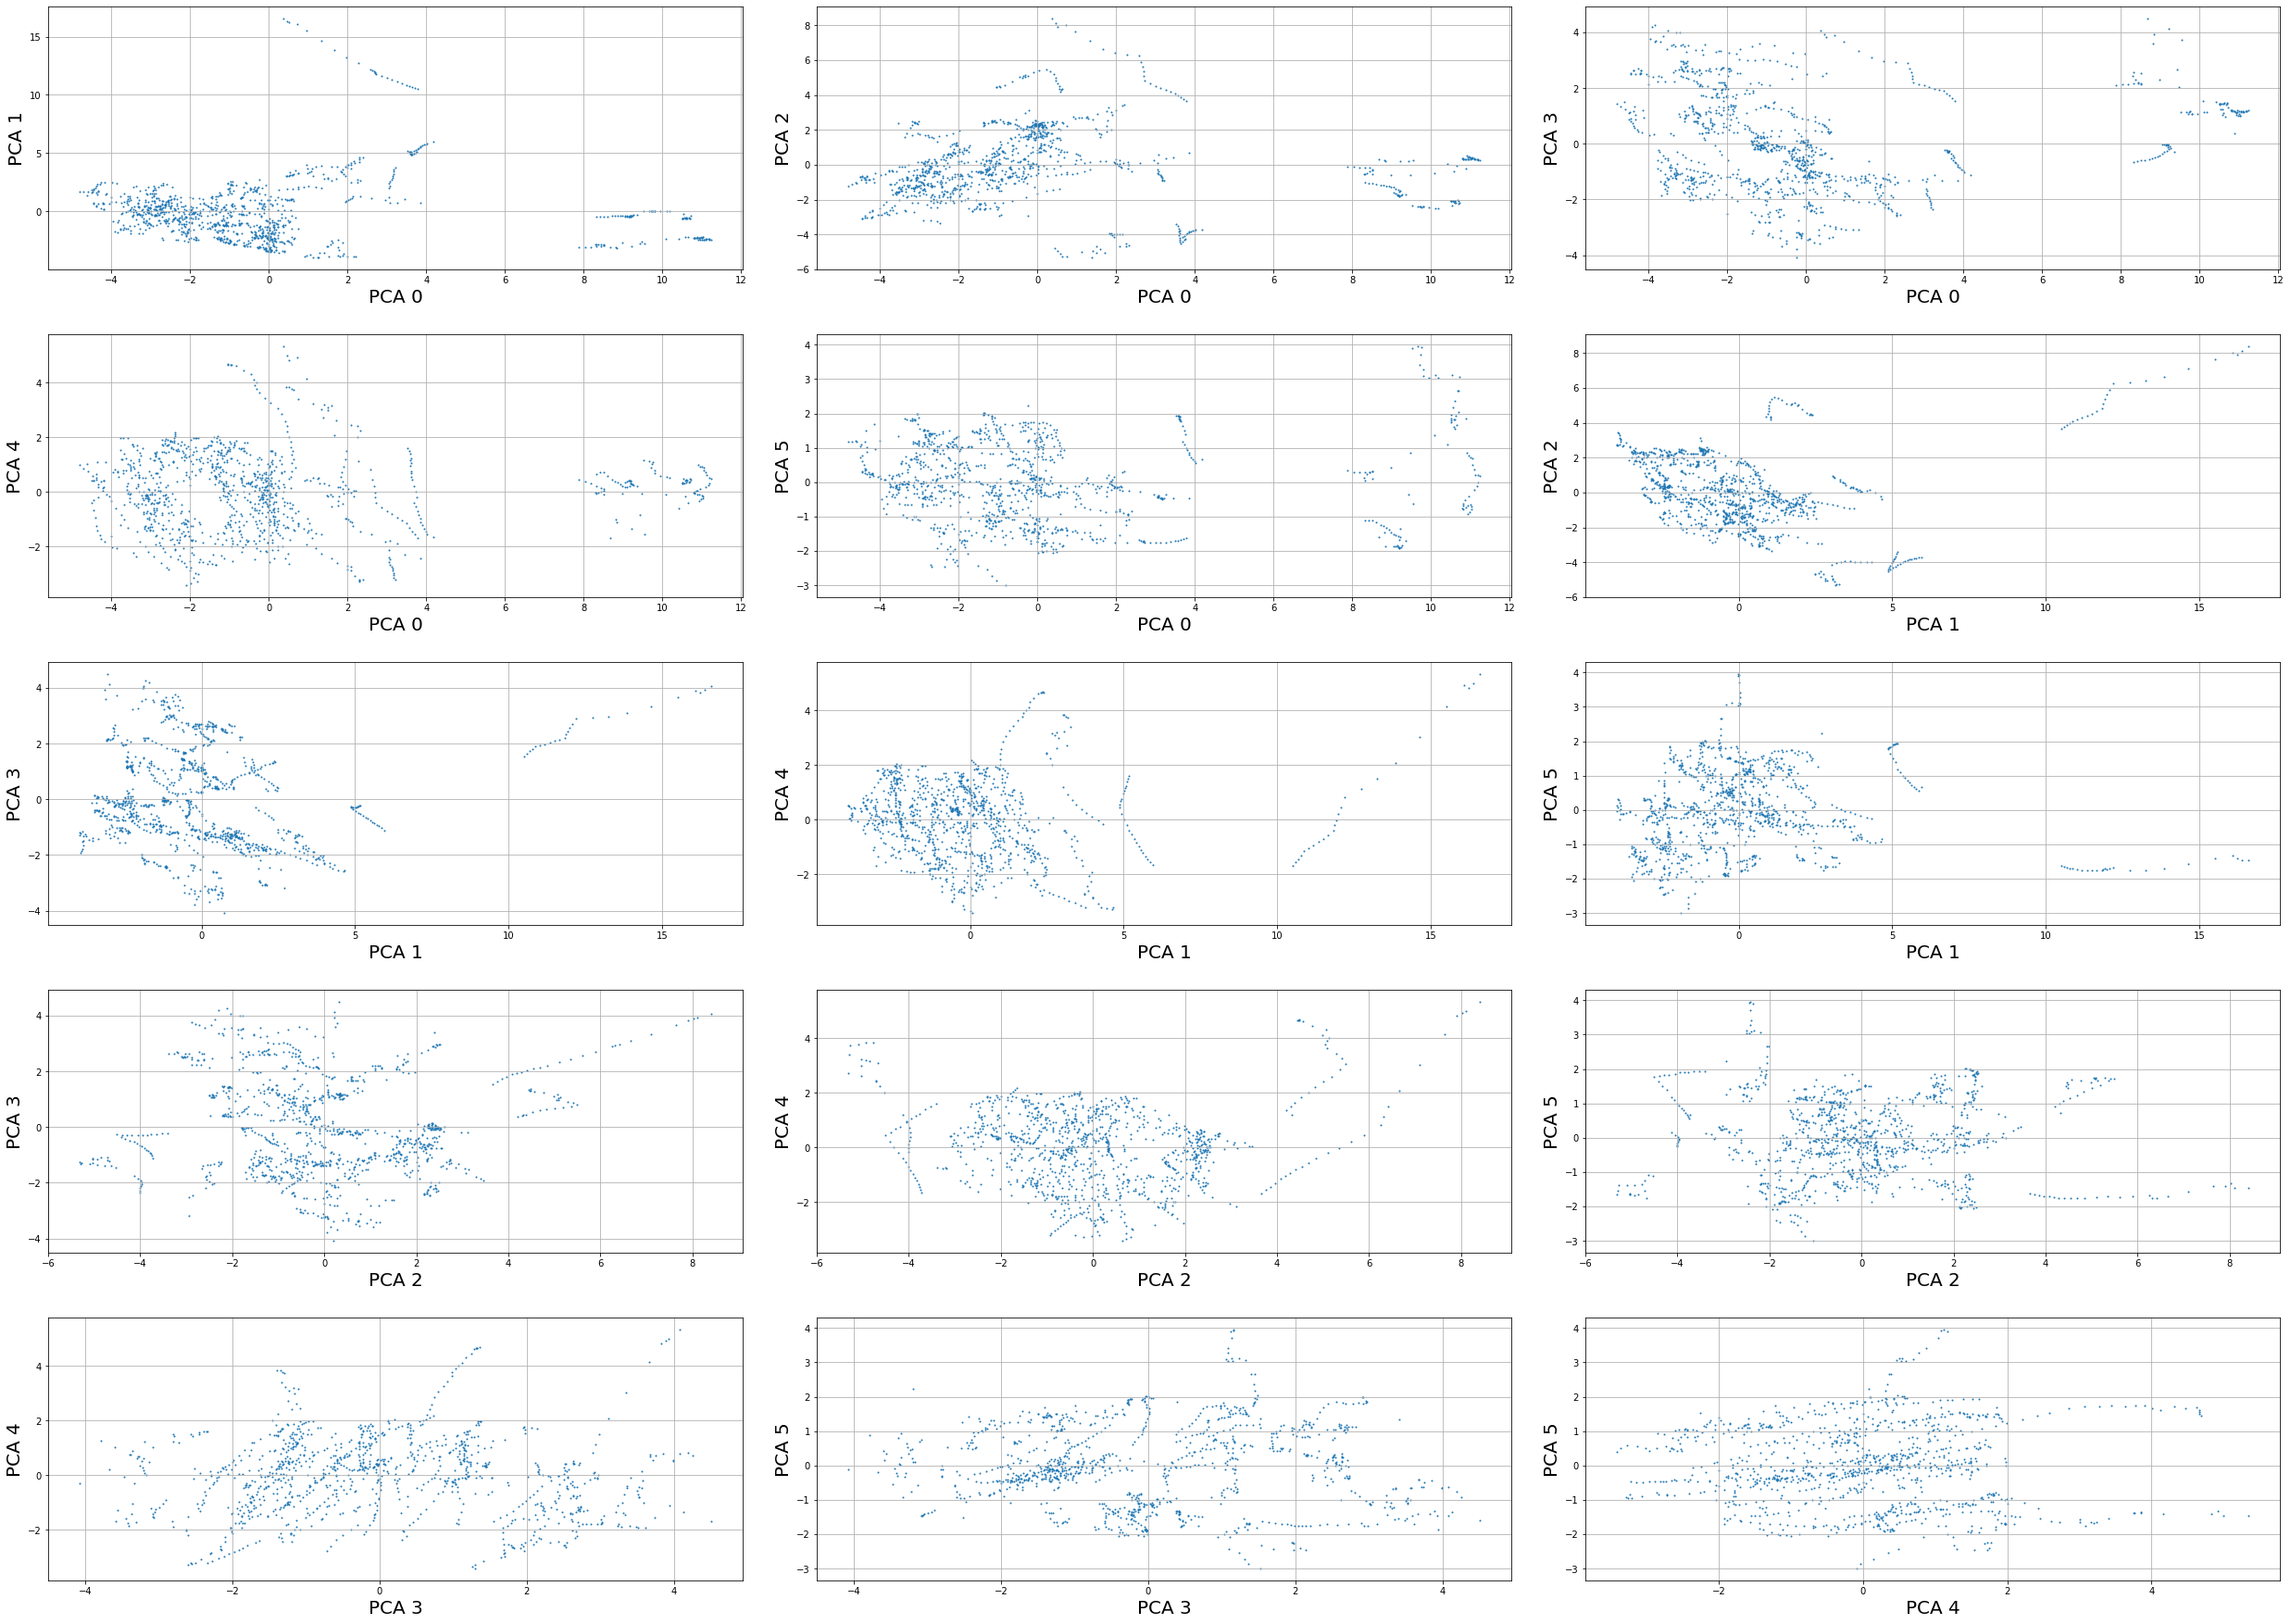

In [28]:
z = 0
n=0
fig, axs = plt.subplots(5, 3, figsize = (35,25))
for i in range(0,6):
  for j in range(i+1,6):
    axs[n,z].scatter(pca[:, i], pca[:, j], s = 1)
    axs[n,z].set_xlabel(f"PCA {i}", fontsize = 20)
    axs[n,z].set_ylabel(f"PCA {j}", fontsize = 20)
    axs[n,z].grid()
    z += 1
    if z % 3 == 0:
      n += 1
      z = 0
fig.tight_layout(pad=3.0)

## effect of variables on each component

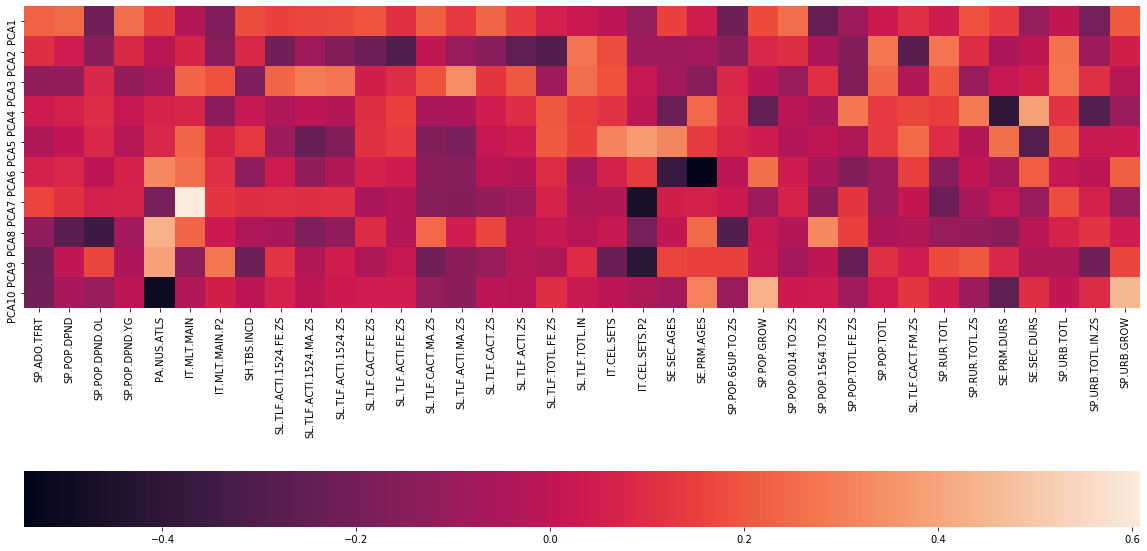

In [29]:
plt.figure(figsize=(20,20))
ax = sns.heatmap(pcamodel.components_,
                 yticklabels=[ "PCA"+str(data_scaled) for data_scaled in range(1,pcamodel.n_components_+1)],
                 xticklabels=list(data_scaled.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

In [30]:
# todo vitalijus: prepare a function that returns indicator names

<prev>
    Taking into place the first 6 PCA's, the top 4 variables with the most influence in these components are:
    
    PCA 1
    -SP.POP.0014.TO.ZS
    -SP.POP.DPND.YG
    -SP.POP.DPND
    -SP.ADO.TFRT
    
    PCA 2
    -SL.TLF.TOTL.IN
    -SP.POP.TOTL
    -SP.RUR.TOTL
    -SP.URB.TOTL
    
    PCA 3
    -SL.TLF.ACTI.MA.ZS
    -LTLF,ACTI.1524.ZS
    -SL.TLF.CACT.FE.ZS
    -SP.URB.TOTL
    
    PCA 4
    -SE.SEC.DURS
    -SP.RUR.TOTL.ZS
    -SP.POP.TOTL.FE.ZS
    -SE.PRM.AGES
    
    PCA 5
    -IT.CEL.SETS.P2
    -SE.SEC.AGES
    -IT.CEL.SETS.P2
    -SE.PRM.DURS
    
    PCA 6
    -PA.NUS.ATLS
    -SP.POP.GROW
    -SE.SEC.DURS
    -SP.URB.GROW
    
<prev/>

## Biplot

In [31]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.figure(figsize=(15,15))
    plt.scatter(xs * scalex,ys * scaley,s=5)
    
    results = []
    
    for i in range(n):
        arrow_color = 'g'
       
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
        if abs(coeff[i,0]) > 0.2 and abs(coeff[i,1]) > 0:
            #print(labels[i])
            results.append(labels[i])
            #arrow_color = 'b'
         
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color =  arrow_color,alpha = 0.5)

 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    return results

influential_attributes = []

[['SP.ADO.TFRT', 'SP.POP.DPND', 'SP.POP.DPND.OL', 'SP.POP.DPND.YG', 'SL.TLF.CACT.MA.ZS', 'SL.TLF.CACT.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.TO.ZS', 'SP.URB.GROW']]


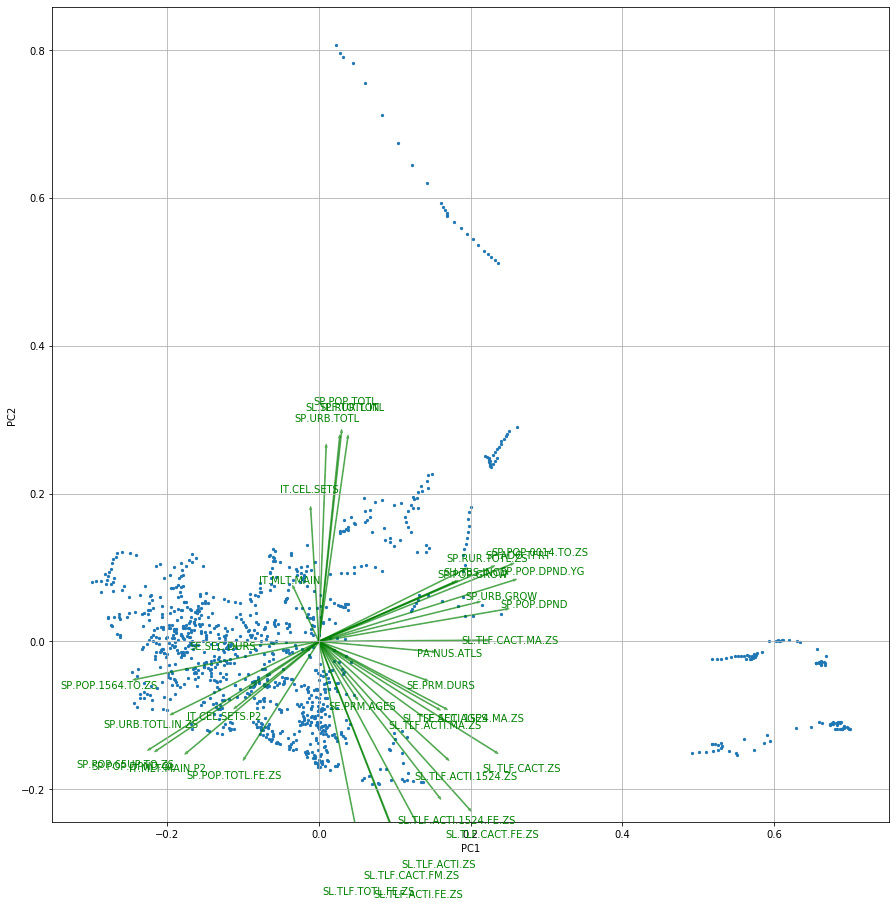

In [32]:
temp = myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(data_scaled.columns))
influential_attributes.append(temp)
print(influential_attributes)

In [33]:
indicators_df[indicators_df['IndicatorCode'].isin(influential_attributes[0])]["IndicatorName"].unique()

array(['Adolescent fertility rate (births per 1,000 women ages 15-19)',
       'Age dependency ratio (% of working-age population)',
       'Age dependency ratio, old (% of working-age population)',
       'Age dependency ratio, young (% of working-age population)',
       'Population ages 65 and above (% of total)',
       'Population, ages 0-14 (% of total)',
       'Population, ages 15-64 (% of total)',
       'Urban population growth (annual %)',
       'Labor force participation rate, male (% of male population ages 15+) (modeled ILO estimate)',
       'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)'],
      dtype=object)

### Heirarchical Clustering

In [34]:
X = data_final.iloc[:,:].values

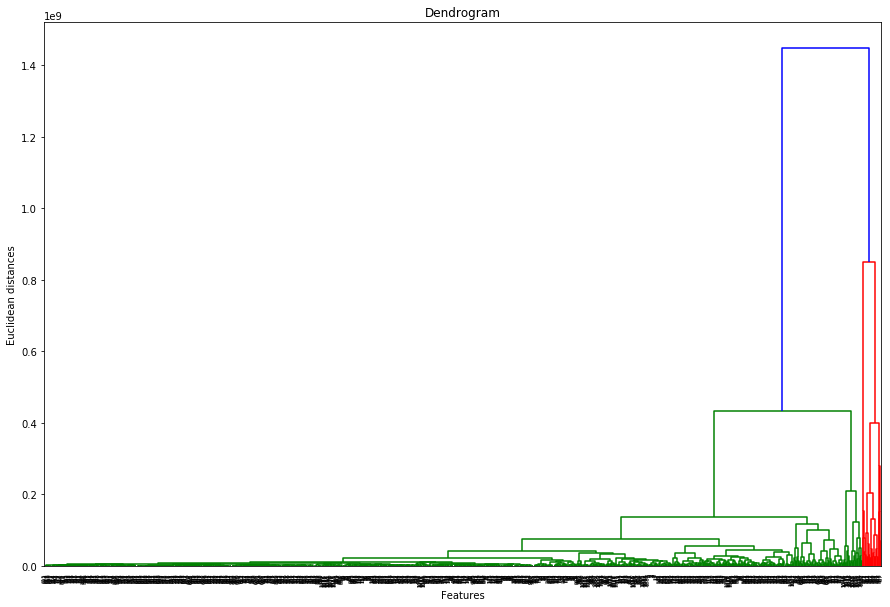

In [35]:
plt.figure(figsize=(15,10))
dendrogram = sch.dendrogram(sch.linkage(X, method  = "average"))
plt.title('Dendrogram')
plt.xlabel('Features')
plt.ylabel('Euclidean distances')
plt.show()

In [36]:
hc = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean', linkage ='ward') ###use; average, complete and singular methods
y_hc=hc.fit_predict(X)

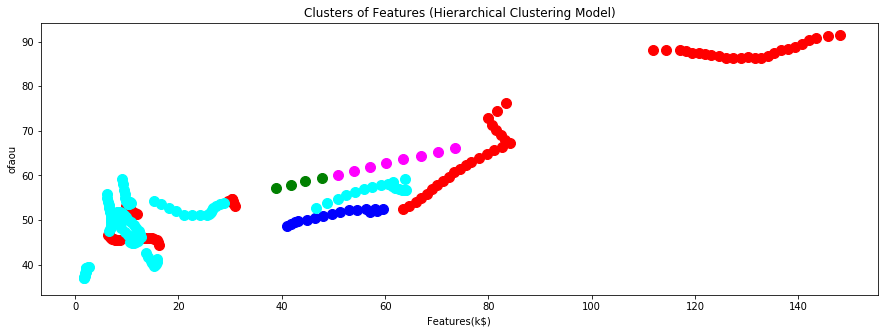

In [37]:
plt.figure(figsize=(15,5))
plt.scatter(X[y_hc==0, 0], X[y_hc==0, 1], s=100, c='red', label ='Cluster 1')
plt.scatter(X[y_hc==1, 0], X[y_hc==1, 1], s=100, c='blue', label ='Cluster 2')
plt.scatter(X[y_hc==2, 0], X[y_hc==2, 1], s=100, c='green', label ='Cluster 3')
plt.scatter(X[y_hc==3, 0], X[y_hc==3, 1], s=100, c='cyan', label ='Cluster 4')
plt.scatter(X[y_hc==4, 0], X[y_hc==4, 1], s=100, c='magenta', label ='Cluster 5')
plt.title('Clusters of Features (Hierarchical Clustering Model)')
plt.xlabel('Features(k$)')
plt.ylabel('ofaou')
plt.show()

In [38]:
# todo kobina: describtion, docstrings, references

In [39]:
#FOR CLUSTERING OF COUNTRIES (LOWER THRESHOLD REQUIRED TO OBTAIN MORE DATA)
processed_attributes , n_years= create_df(0.3, 0.85, 1990,2015)
country_list = get_country_list(processed_attributes)
a = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform(data_scaled)

Adding ARG 0.4833035714285714
Adding AUS 0.4632440476190476
Adding AUT 0.4811607142857143
Adding BEL 0.463125
Adding CAN 0.4529761904761904
Adding CZE 0.49872023809523813
Adding DNK 0.4911011904761905
Adding ECU 0.6455654761904762
Adding EST 0.45895833333333336
Adding FIN 0.4933630952380952
Adding FRA 0.48684523809523805
Adding DEU 0.4795238095238096
Adding GRC 0.47627976190476196
Adding HKG 0.38592261904761904
Adding HUN 0.5111011904761904
Adding ISL 0.4392559523809524
Adding IND 0.6361309523809524
Adding IRL 0.47901785714285716
Adding ISR 0.43875
Adding ITA 0.4899404761904762
Adding KOR 0.5043154761904762
Adding LVA 0.45116071428571425
Adding LTU 0.4419047619047619
Adding LUX 0.41770833333333335
Adding MEX 0.6895238095238095
Adding NLD 0.4805952380952381
Adding NZL 0.43675595238095233
Adding NGA 0.5913690476190476
Adding NOR 0.47413690476190473
Adding POL 0.4951488095238096
Adding PRT 0.4770833333333333
Adding RWA 0.5667559523809524
Adding SGP 0.4202678571428572
Adding SVK 0.46220238

In [40]:
pd.isna(data_final).sum().sum()

0

In [41]:
#MAP PCA to their variables
comps = pd.DataFrame(pcamodel.components_, columns = data_final.columns)
n_pcs= pcamodel.n_components_  # get number of component

CREATE DATAFRAME OF THE CORRELATION OF VARIABLES WITH THE FIRST 10 PCA's

In [42]:
#FIRST 10 PCA'S AND HOW MUCH EACH FEAUTRE IS CORRELATED WITH THE PCA
comps.index = [f"PCA {i}" for i in range(1,11)]
comps

,NY.ADJ.DCO2.GN.ZS,NY.ADJ.DCO2.CD,NY.ADJ.DKAP.GN.ZS,NY.ADJ.DKAP.CD,NY.ADJ.AEDU.GN.ZS,NY.ADJ.AEDU.CD,NY.ADJ.DNGY.GN.ZS,NY.ADJ.DNGY.CD,NY.ADJ.ICTR.GN.ZS,NY.ADJ.DMIN.GN.ZS,...,SL.EMP.TOTL.SP.ZS,SL.EMP.1524.SP.FE.ZS,SL.EMP.1524.SP.MA.ZS,SL.EMP.1524.SP.ZS,SL.UEM.TOTL.FE.ZS,SL.UEM.TOTL.MA.ZS,SL.UEM.TOTL.ZS,SL.UEM.1524.FE.ZS,SL.UEM.1524.MA.ZS,SL.UEM.1524.ZS
PCA 1,-0.013257,0.099979,0.035754,0.105258,0.023836,0.104736,-0.018255,0.075557,0.015809,-0.018412,...,-0.030362,-0.010843,-0.016026,-0.013794,-0.006271,-0.005624,-0.006170,-0.002800,0.002675,-0.000051
PCA 2,0.028328,0.063578,-0.078057,0.047878,-0.062956,0.048120,0.031911,0.049076,-0.042162,0.031555,...,0.070592,0.039435,0.051605,0.046984,-0.024277,-0.019668,-0.022389,-0.031678,-0.030526,-0.031916
PCA 3,0.007995,-0.025997,0.020570,-0.030617,-0.011144,-0.034142,-0.008846,-0.032561,0.046621,-0.006316,...,-0.003806,-0.019509,-0.034466,-0.027753,-0.020414,-0.018530,-0.020012,-0.014602,-0.012046,-0.013879
PCA 4,0.132072,0.015999,-0.002708,-0.012905,-0.039221,-0.013296,0.020794,-0.011132,-0.020485,-0.010334,...,-0.145319,-0.156753,-0.109853,-0.138424,0.114485,0.094522,0.106808,0.115963,0.101105,0.110666
PCA 5,0.001236,-0.002698,-0.071254,-0.025087,-0.075877,-0.024618,0.043597,0.013235,0.132056,-0.001789,...,0.024000,0.004220,0.033032,0.019003,-0.095864,-0.102537,-0.103263,-0.085419,-0.097532,-0.094028
PCA 6,-0.022253,-0.003622,-0.021836,0.026826,-0.070949,0.023999,-0.019155,-0.010255,-0.032012,0.045002,...,-0.045512,-0.065549,-0.122817,-0.096755,0.100400,0.111136,0.110361,0.104903,0.110500,0.110581
PCA 7,0.038499,0.015620,-0.004316,0.005749,-0.006479,0.006483,-0.122137,-0.027916,0.003732,-0.079375,...,0.044401,0.038498,0.041404,0.041155,-0.049384,-0.066355,-0.060339,-0.063699,-0.084219,-0.075603
PCA 8,-0.095743,-0.021907,-0.010830,-0.000805,-0.009062,-0.006570,-0.091168,-0.058849,-0.040358,-0.099665,...,0.009552,-0.009822,-0.005904,-0.007581,-0.058589,-0.082799,-0.074468,-0.039964,-0.056487,-0.049112
PCA 9,-0.039585,-0.015317,-0.086165,0.016088,-0.057473,0.016842,0.196286,0.048467,-0.036005,-0.149550,...,-0.040848,-0.025364,-0.005510,-0.017083,-0.054272,-0.086579,-0.075390,-0.059676,-0.084627,-0.074981
PCA 10,-0.032412,-0.009077,-0.061540,-0.022083,0.062603,-0.017756,-0.016829,0.008758,-0.121541,-0.042027,...,0.007701,0.036517,0.068262,0.053385,0.028136,-0.024541,-0.001739,0.029794,-0.005161,0.010036


In [43]:
#BELOW, I WILL FIND THE NUMBER FEATURES ABOVE A CERTAIN ABSOLUTE CORRELATION 
#THRESHOLD FOR THE FIRS 2 PCAS. #I'M AIMING FOR A NUMBER SMALL ENOUGH THAT THE 
#DTW RUNS QUICKLY, BUT LARGE ENOUGH THAT I GET GOOD RESULTS.

#CONDITION TO HELP ME REMOVE COLUMNS 
def makena(x):
  if x == False:
    return(np.nan)
  else:
    return True
def find_influential(n_pca,threshold):
  comp_bool = (abs(comps)>threshold)[0:n_pca]
  comp_bool = comp_bool.applymap(makena)
  comp_bool.dropna(thresh=2,axis=1,inplace=True)
  influential = comp_bool.columns
  print(f"{len(influential)} indicators selected")
  return (influential)
influential = find_influential(2,0.055)

50 indicators selected


CLUSTERING


NORMALIZATION, SCALING AND GROUPING BY COUNTRY

In [44]:
ind_dist_mat = 1-abs(processed_attributes[influential].corr())

In [45]:
#list(indicators_countries[indicators_countries["IndicatorCode"].isin(influential)]["IndicatorName"])

In [46]:
#Determine the number of countries were working with
n_countries = len(a)

In [47]:
#Filter selected features from scaled dataframe and assign to variable
clustering_df_pre = data_scaled[influential]
n_years = n_years 
#Create list where each index is the dataframe containing the multivariate time 
#series for each country
clustering_df = []
for i in range(n_countries):
  clustering_df.append(clustering_df_pre[(n_years)*i: (n_years)*(i+1)])

In [48]:
#VECTORIZED IMPLEMENTATION OF THE DTW ALGORITHM. 
#c1 = country 1, c2 = country2
#1. PERFORM DTW between indicatorA (c1) and indicatorA(c2)
#to compute total distance between indicators (scalar (x_n))
#2. APPLY over time all time series between country1 and country2 to 
# to obtain vector v(x_1,x_2,x_3)
#3. FIND mean of resultant vector M_c1_c2 (this is the distance between c1 & c2)
#4. Repeat for all combinations of c_i & c_j where i != j

#BETWEEN THE DISSIMILARITY BETWEEN THE SET OF TIME SERIES FOR ONE COUNTRY AND THE SET 
#OF TIME SERIES FOR ANOTHER. IT MAY BE USEFUL TO WRITE THE PSEUDOCODE IN LATEX
#FOR EASY COMPREHENSION.
def total_dtw(x,y):
  return (list(map(lambda a, b : fastdtw(a, b, dist=euclidean)[0],x,y)))
def get_distances(i, offset, df_table):
  ts1 = np.array(df_table[i][::offset].transpose())
  if offset >1:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))
  else:
      return list(map(lambda b: np.mean(total_dtw(ts1,np.array(df_table[b][::offset].transpose()))), range(i+1,len(clustering_df))))

res = list(map(lambda x: get_distances(x, 10, clustering_df), range(0,len(clustering_df))))

In [49]:
import numpy as np
zero_mat = np.zeros([len(res),len(res)])
for i in range(len(zero_mat)):
  zero_mat[i,i+1:] = res[i]

In [50]:
#VISUALIZE DISTANCE MATRIX
dist_mat = np.array(zero_mat) + np.array(zero_mat).transpose()
dist_mat = pd.DataFrame(dist_mat/np.max(dist_mat))
np.mean(np.max(dist_mat))
dist_mat.columns = country_list
dist_mat.index = country_list
ind_dist_mat = processed_attributes[influential].corr()
ind_dist_mat = np.abs(ind_dist_mat)

In [51]:
from sklearn.cluster import AgglomerativeClustering
def cluster(dist_mat, thresh):
  cluster = AgglomerativeClustering(n_clusters=None, affinity='euclidean', linkage='ward', distance_threshold=thresh)
  prediction = cluster.fit_predict(dist_mat)
  return (prediction)
names = country_list
def get_c_dict(dist_mat, prediction, names):
  c_dict = {}
  names = dist_mat.columns
  for i in range(dist_mat.shape[0]):
    try:
      c_dict[prediction[i]].append(names[i])
    except:
      c_dict.update({prediction[i]:[names[i]]})
  return c_dict
c_pred = cluster(dist_mat, 0.95)
c_dict_ind = cluster(ind_dist_mat, 1.2)
c_dict=get_c_dict(dist_mat,c_pred, names)
c_dict_ind = get_c_dict(ind_dist_mat, c_dict_ind, ind_dist_mat.columns)


In [52]:
c_dict_ind

{1: ['NY.ADJ.DCO2.CD',
  'AG.PRD.CREL.MT',
  'EN.ATM.CO2E.KT',
  'EN.ATM.CO2E.LF.KT',
  'EN.ATM.CO2E.SF.KT',
  'NY.GDP.MKTP.PP.KD',
  'NY.GDP.MKTP.PP.CD',
  'NY.GNP.MKTP.PP.CD',
  'NE.CON.PRVT.PP.CD',
  'NE.CON.PRVT.PP.KD'],
 0: ['SP.POP.DPND',
  'SP.POP.DPND.YG',
  'NV.AGR.TOTL.ZS',
  'SP.DYN.CBRT.IN',
  'SP.DYN.TFRT.IN',
  'SH.MMR.RISK.ZS',
  'SH.STA.MMRT',
  'SP.DYN.IMRT.IN',
  'SH.DYN.NMRT',
  'SH.DYN.MORT',
  'SP.POP.0014.TO.ZS',
  'SP.POP.1564.TO.ZS',
  'SH.ANM.CHLD.ZS'],
 3: ['AG.LND.AGRI.K2', 'EN.URB.LCTY'],
 8: ['NV.AGR.TOTL.KD',
  'NV.AGR.TOTL.CD',
  'AG.LND.ARBL.HA',
  'MS.MIL.TOTL.P1',
  'SP.URB.TOTL'],
 6: ['EN.ATM.CO2E.PC'],
 4: ['SL.SRV.EMPL.ZS',
  'NY.GNP.PCAP.CD',
  'NE.CON.PRVT.PC.KD',
  'NY.GDP.PCAP.PP.KD',
  'NY.GDP.PCAP.PP.CD',
  'NY.GNP.PCAP.PP.CD'],
 2: ['IT.MLT.MAIN.P2', 'SL.GDP.PCAP.EM.KD', 'SH.ANM.NPRG.ZS', 'SH.PRG.ANEM'],
 5: ['NY.GDP.FRST.RT.ZS', 'EG.FEC.RNEW.ZS'],
 7: ['SP.DYN.LE00.FE.IN',
  'SP.DYN.LE00.MA.IN',
  'SP.DYN.LE00.IN',
  'SP.DYN.AMRT.FE',
  'SP

In [53]:
c_dict

{1: ['ARG', 'ECU', 'MEX', 'ZAF'],
 0: ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'CHE',
  'CZE',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'ITA',
  'KOR',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'PRT',
  'SGP',
  'SVN',
  'SWE'],
 2: ['EST', 'HUN', 'LTU', 'LVA', 'POL', 'SVK'],
 4: ['IND'],
 3: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 5: ['USA']}

Try multiple linkages of agglomerative heirarchical clustering.

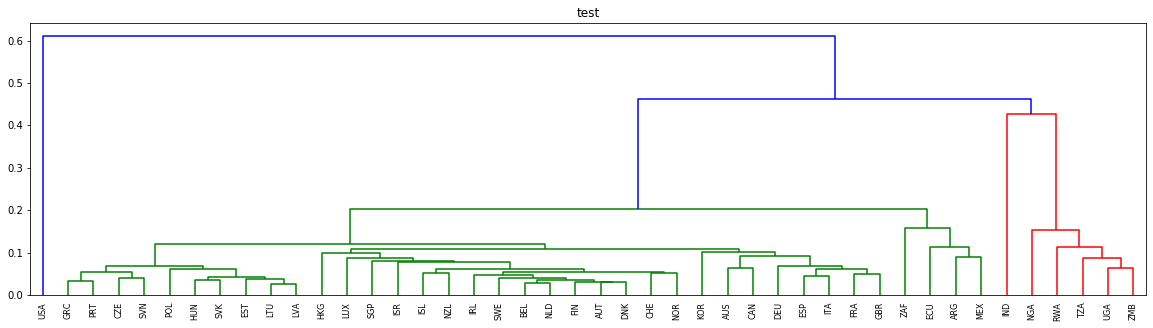

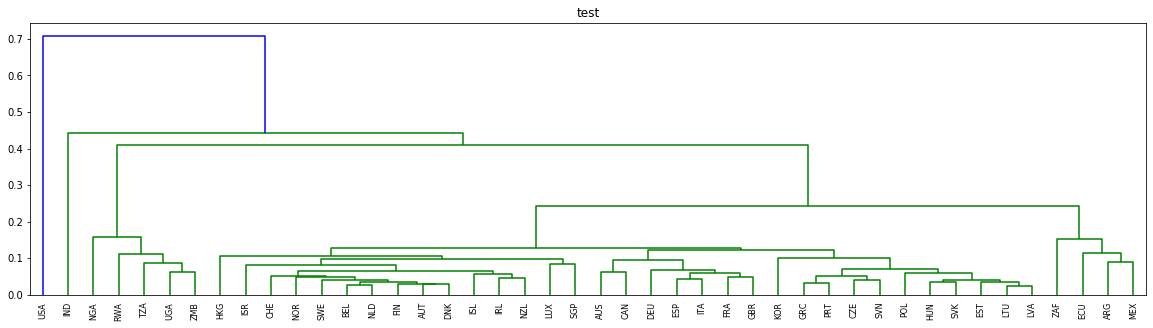

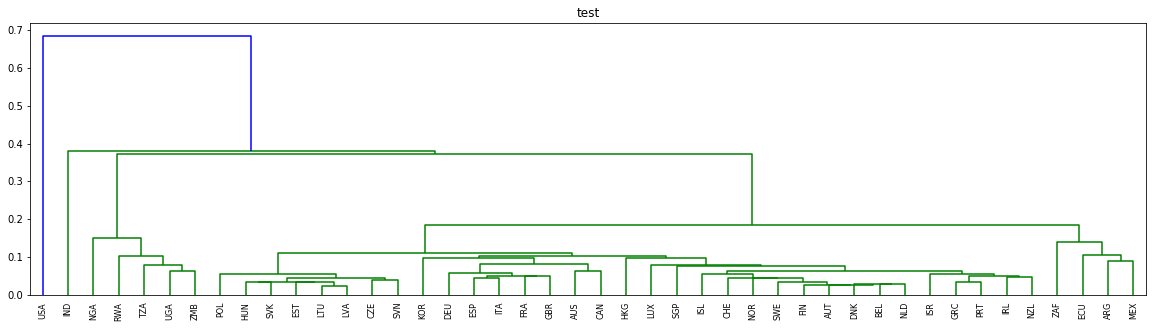

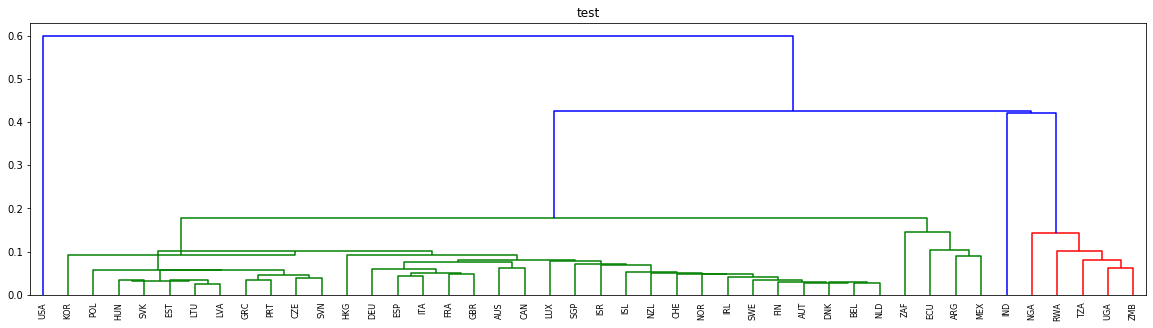

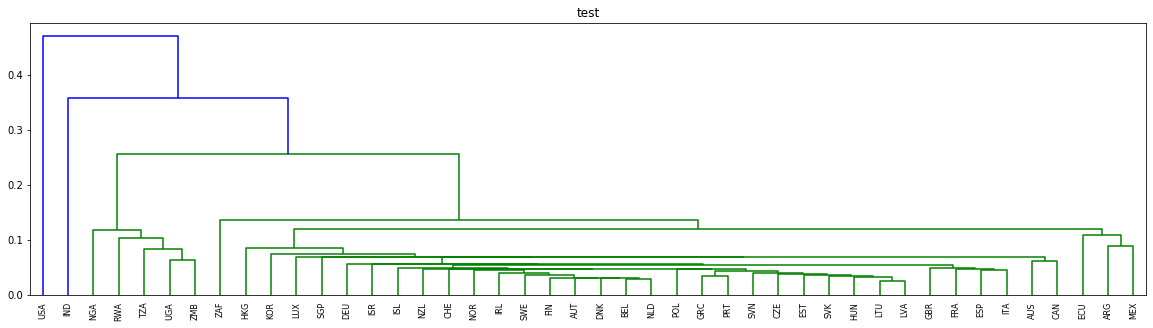

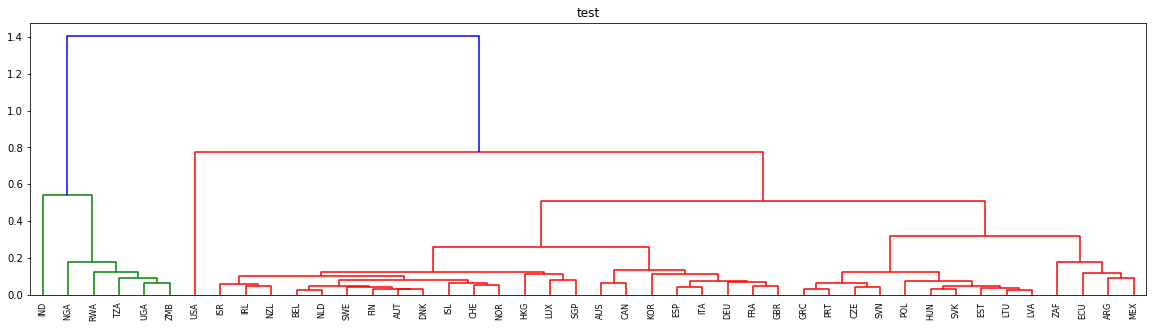

In [54]:
#CREATE DICTIONARY OF KEY = COUNTRIES AND THEIR VALUE =CLUSTER 
#(MAY BE USEFUL LATER ON )
a = pd.DataFrame(pd.Series(c_dict))
a.reset_index(inplace = True)
names = []
n_clusters = 6
for i in range(n_clusters):
  names.append(list(a[a[0] == i]['index'].values))

#ENSURE THAT DISTANCE MATRIX IS SYMMETRICAL (PREREQUISITE FOR AGG-HEIR)
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(dist_mat)

#PLOT DENDOGRAM (CLUSTERING FINITO)
methods = ["average", "weighted", "median", "centroid", "single", "ward"]
dists = squareform(dist_mat)
for method in methods:
  linkage_matrix = linkage(dists, method)
  plt.figure(figsize = (20,5))
  dendrogram = sch.dendrogram(linkage_matrix, labels = country_list)
  plt.title("test")
  plt.show()  

In [55]:
initial_medoids = [1,2,3,4,5,6]
kmedoids_instance = kmedoids(np.array(dist_mat),initial_medoids,data_type='distance_matrix')
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
c_list = list(map(lambda x: list(np.array(country_list)[np.array(x)]),clusters))
c_dict = dict(zip(range(0,6),c_list))
c_dict

{0: ['USA'],
 1: ['AUS',
  'AUT',
  'BEL',
  'CAN',
  'CHE',
  'DEU',
  'DNK',
  'ESP',
  'FIN',
  'FRA',
  'GBR',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'ITA',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'SGP',
  'SWE'],
 2: ['IND'],
 3: ['ARG', 'ECU', 'MEX', 'ZAF'],
 4: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 5: ['CZE', 'EST', 'HUN', 'KOR', 'LTU', 'LVA', 'POL', 'PRT', 'SVK', 'SVN']}

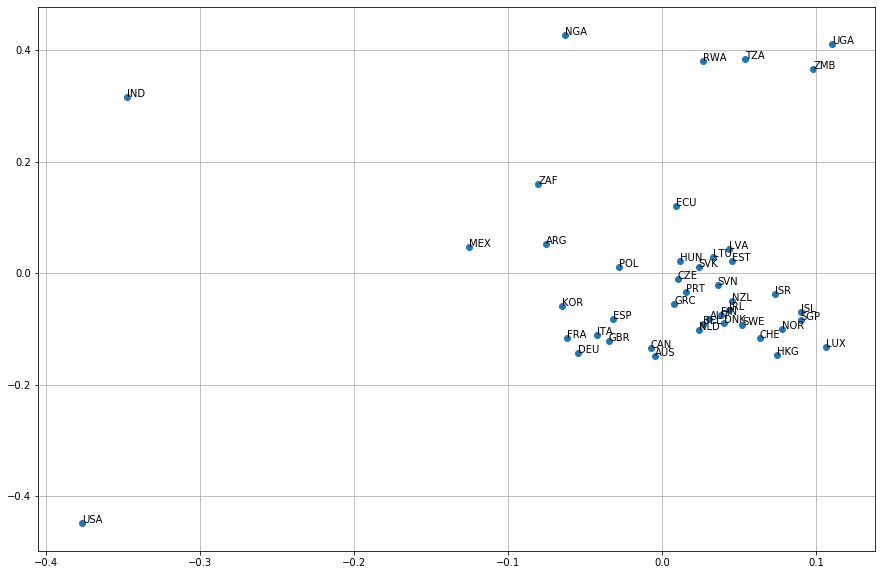

In [56]:
mds_model = manifold.MDS(n_components = 2, random_state = 123, dissimilarity = 'precomputed')
mds_fit = mds_model.fit(np.array(dist_mat))  
mds_coords = mds_model.fit_transform(np.array(dist_mat))
plt.figure( figsize = (15,10))
plt.scatter(mds_coords[:,0],mds_coords[:,1])
for j in range(mds_coords.shape[0]):
  plt.annotate(country_list[j], (mds_coords[j,0],mds_coords[j,1]), fontsize = 10)
plt.grid()
zip(mds_coords)

In [57]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 6)
prediction = model.fit(mds_coords)
prediction = prediction.labels_
c_dict = {}
names = country_list
get_c_dict(dist_mat,prediction, names)

{1: ['ARG',
  'CZE',
  'ECU',
  'EST',
  'HUN',
  'LTU',
  'LVA',
  'MEX',
  'POL',
  'SVK',
  'ZAF'],
 0: ['AUS', 'CAN', 'DEU', 'ESP', 'FRA', 'GBR', 'ITA', 'KOR'],
 5: ['AUT',
  'BEL',
  'CHE',
  'DNK',
  'FIN',
  'GRC',
  'HKG',
  'IRL',
  'ISL',
  'ISR',
  'LUX',
  'NLD',
  'NOR',
  'NZL',
  'PRT',
  'SGP',
  'SVN',
  'SWE'],
 4: ['IND'],
 2: ['NGA', 'RWA', 'TZA', 'UGA', 'ZMB'],
 3: ['USA']}

In [58]:
processed_attributes , n_years= create_df(0.3, 0.8, 1960,2015)
country_list = get_country_list(processed_attributes)
a = impute_a(processed_attributes,range(0,len(country_list)))
data_final = pd.concat(a)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_final)
data_scaled = pd.DataFrame(data_scaled, columns=data_final.columns)

Adding ARG 0.350392316017316
Adding AUS 0.3419237012987013
Adding AUT 0.34450757575757573
Adding BEL 0.31670725108225106
Adding CAN 0.33256222943722946
Skipping CZE 0.2584686147186147
Adding DNK 0.3449810606060606
Adding ECU 0.483103354978355
Skipping EST 0.2291801948051948
Adding FIN 0.35238095238095235
Adding FRA 0.3561011904761905
Adding DEU 0.3127299783549784
Adding GRC 0.3482683982683983
Skipping HKG 0.2756087662337663
Adding HUN 0.30086580086580084
Skipping ISL 0.29894480519480515
Adding IND 0.48221049783549785
Adding IRL 0.3337797619047619
Adding ISR 0.3044778138528138
Adding ITA 0.35292207792207797
Adding KOR 0.3798701298701299
Skipping LVA 0.22474296536796534
Skipping LTU 0.22031926406926405
Skipping LUX 0.28118235930735935
Adding MEX 0.5028138528138528
Adding NLD 0.35576298701298703
Adding NZL 0.31124188311688317
Adding NGA 0.42349837662337664
Adding NOR 0.3432900432900433
Skipping POL 0.2857548701298701
Adding PRT 0.3393668831168831
Adding RWA 0.4287472943722944
Adding SGP 0

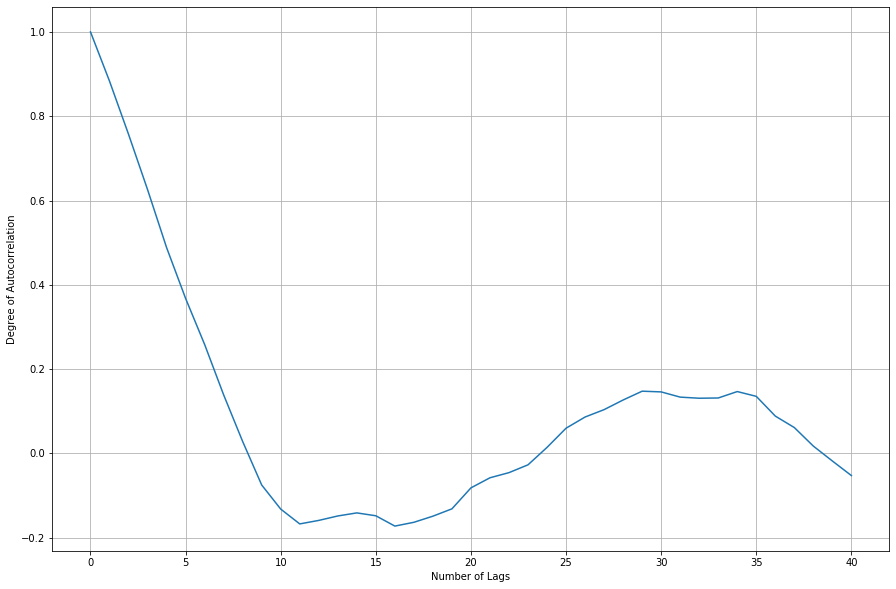

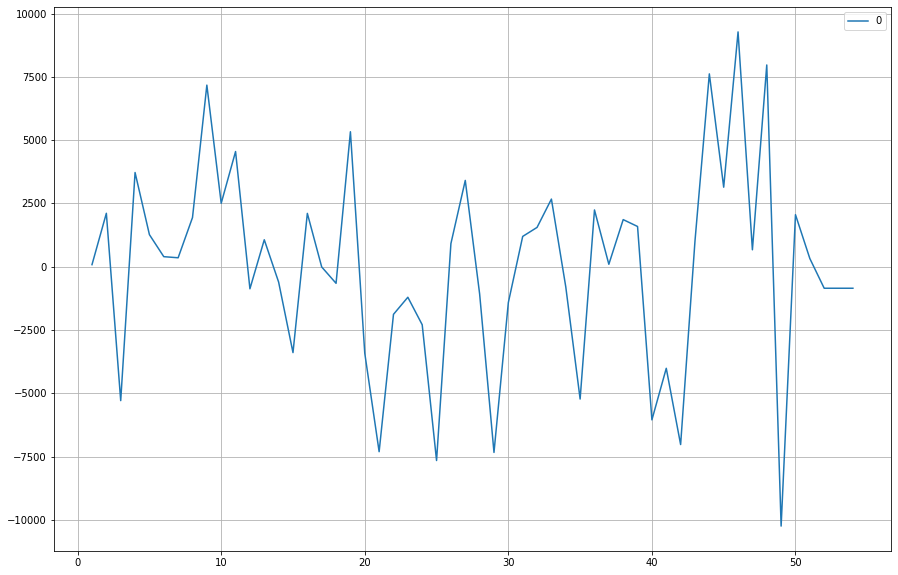

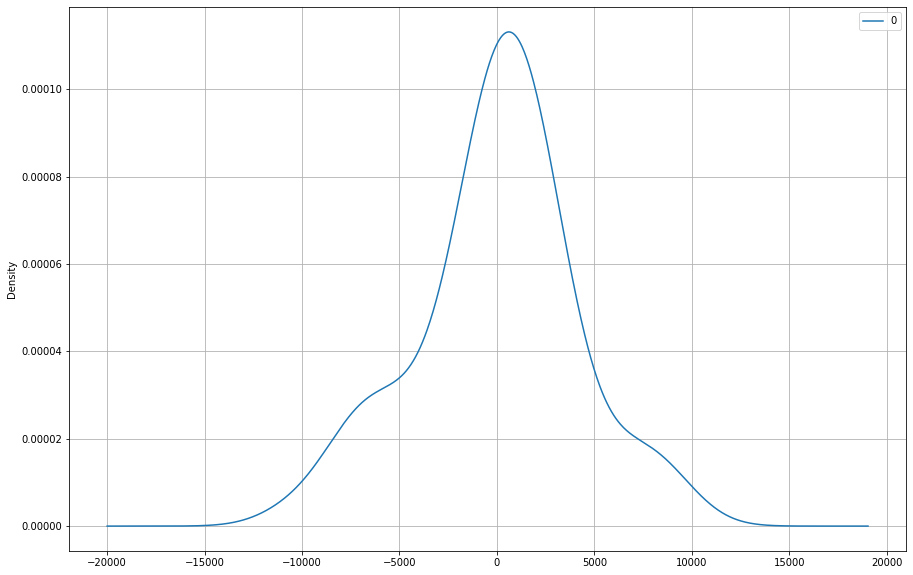

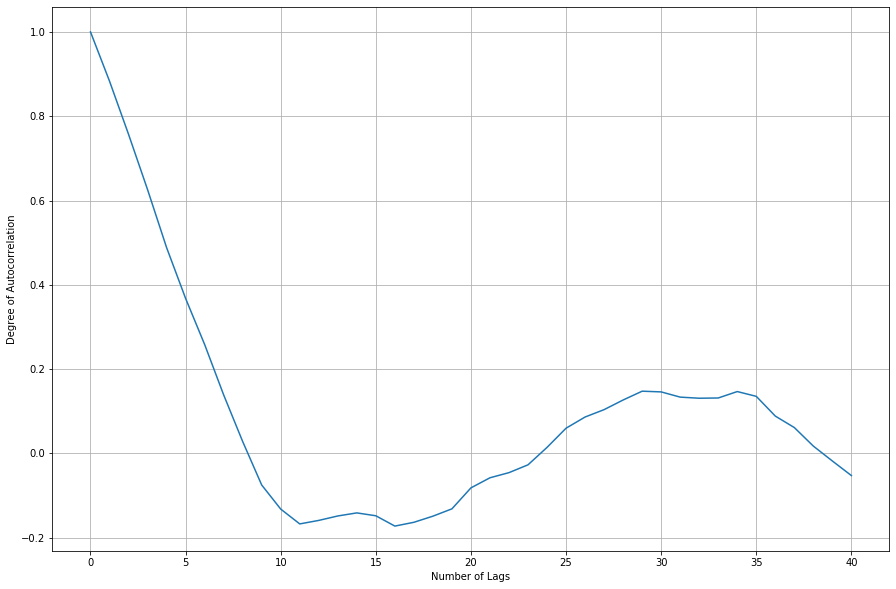

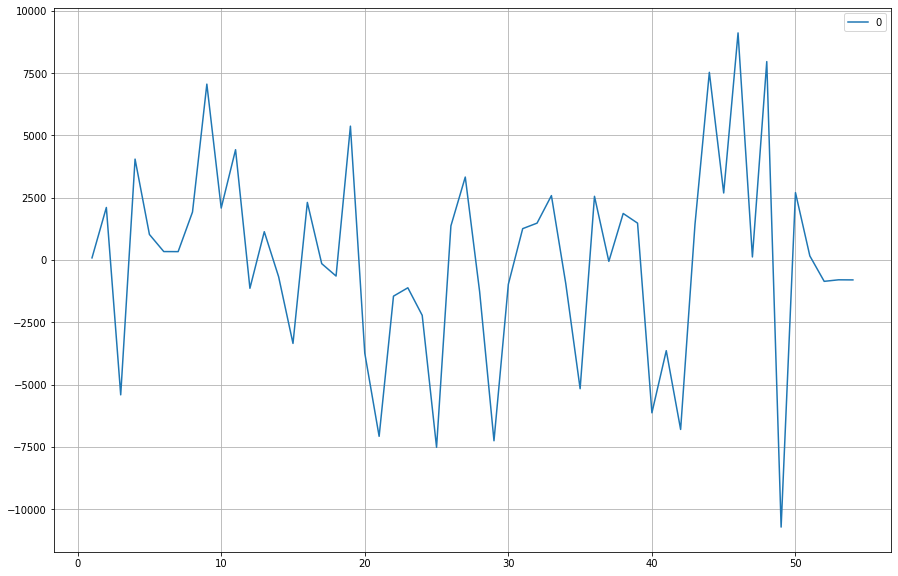

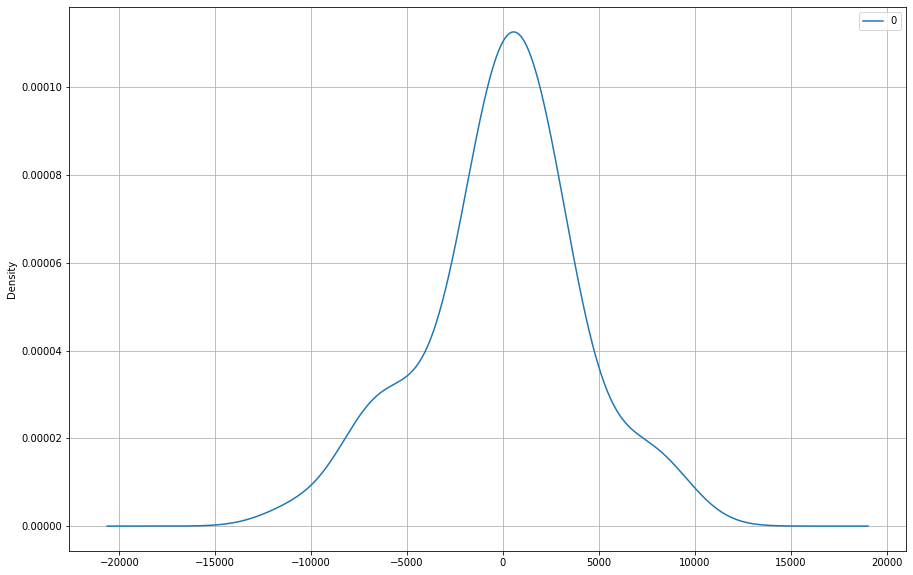

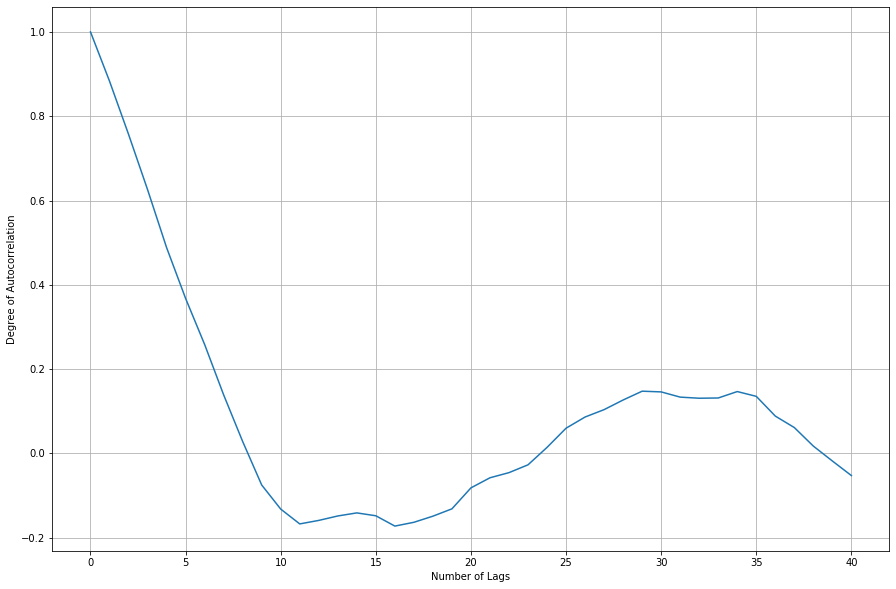

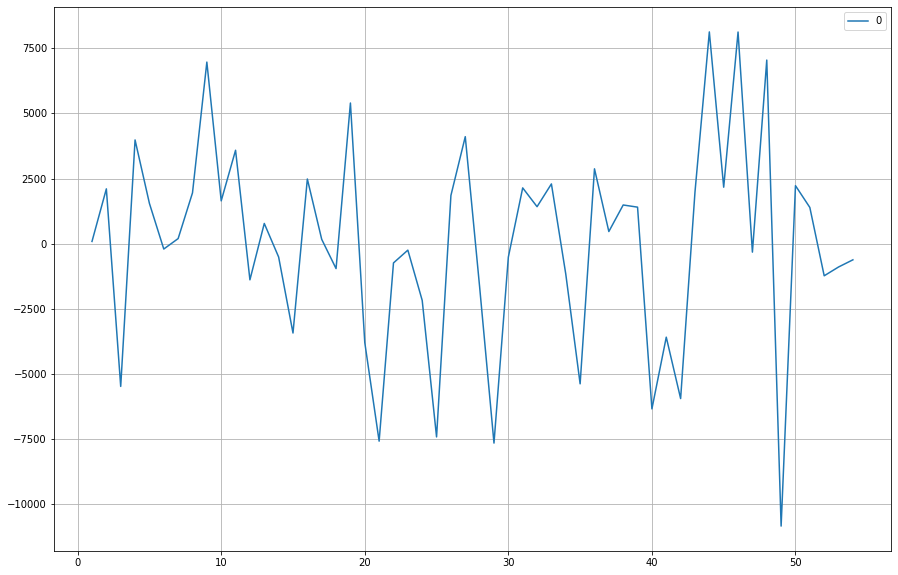

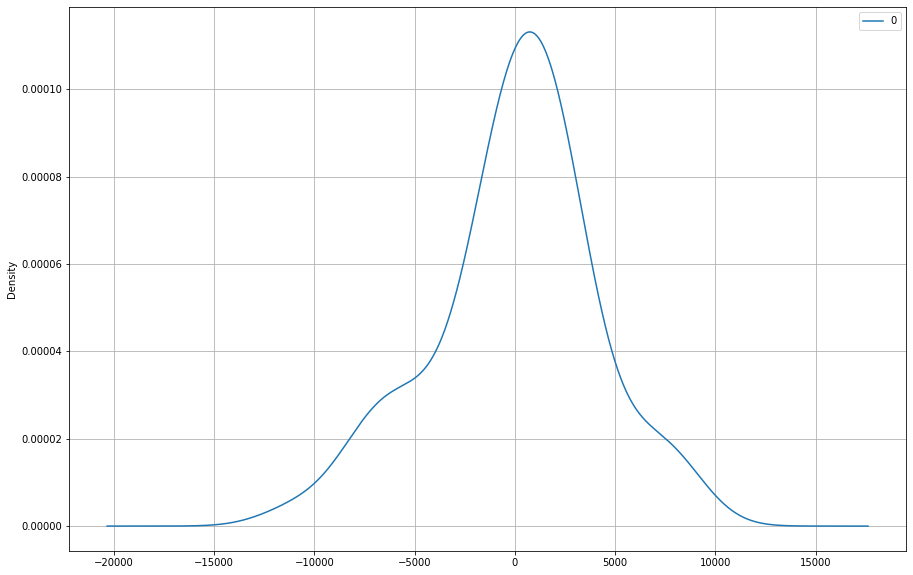

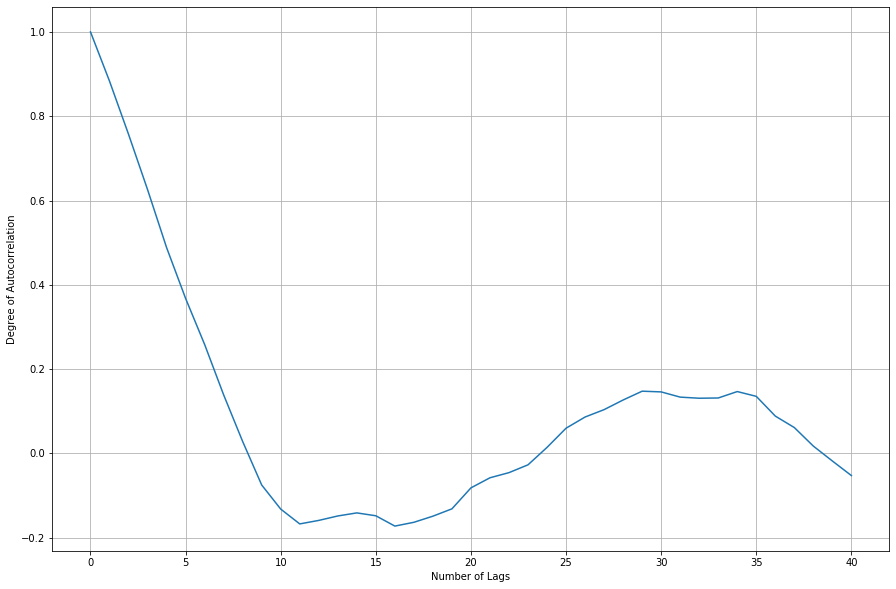

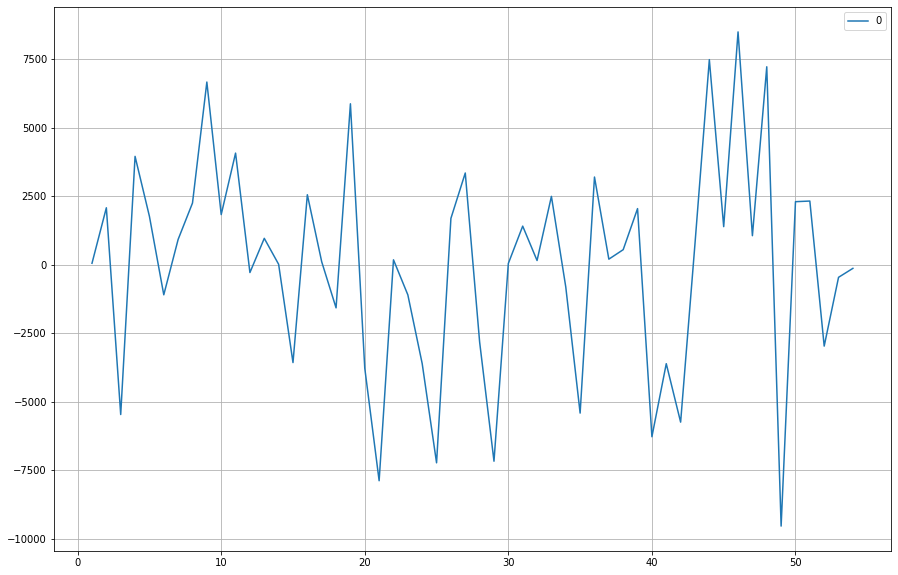

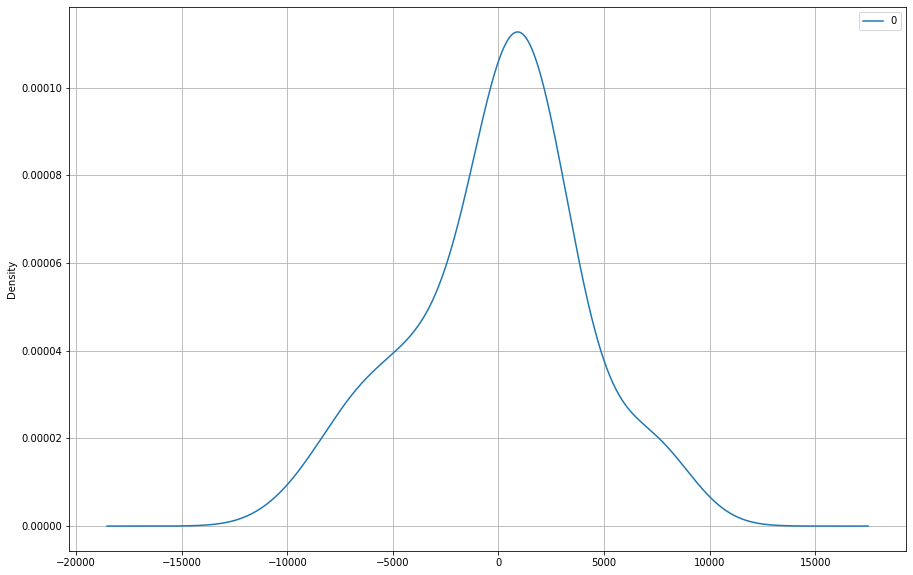

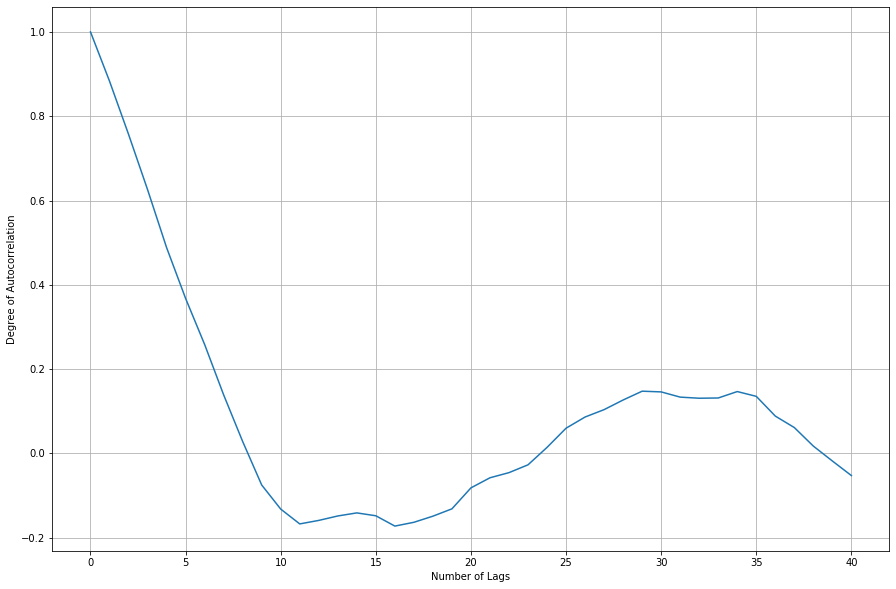

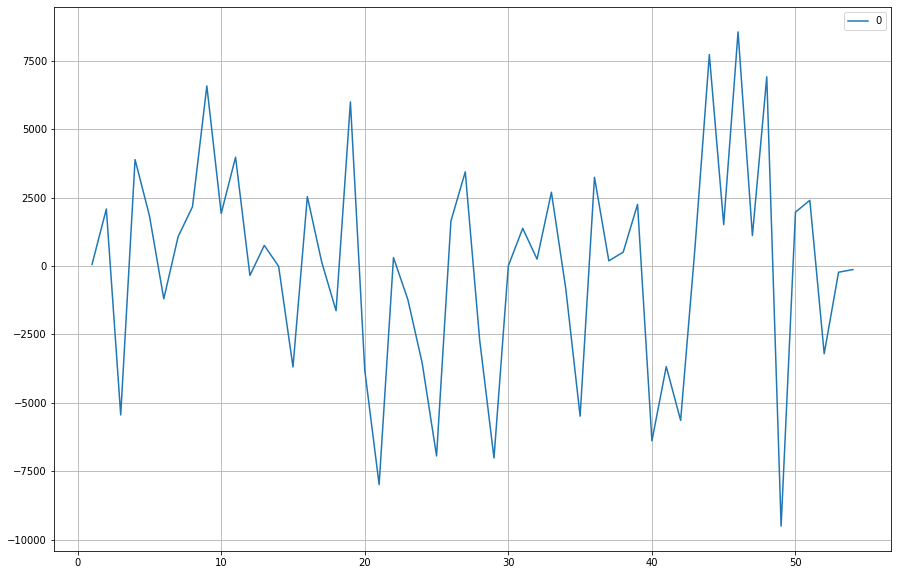

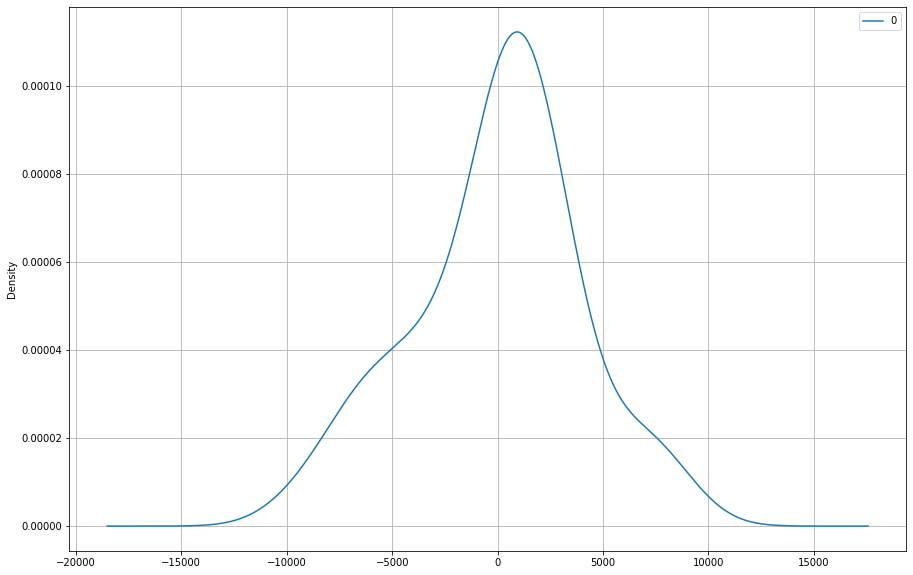

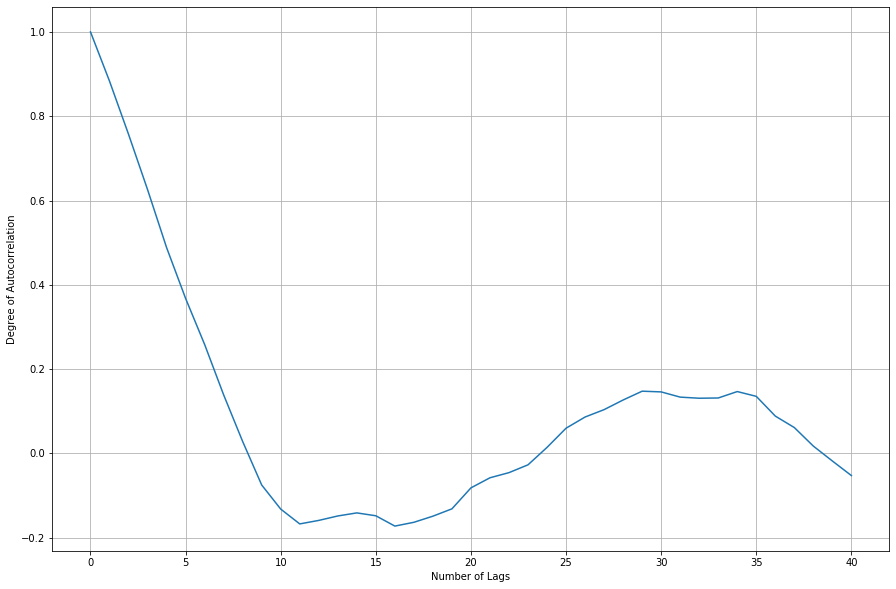

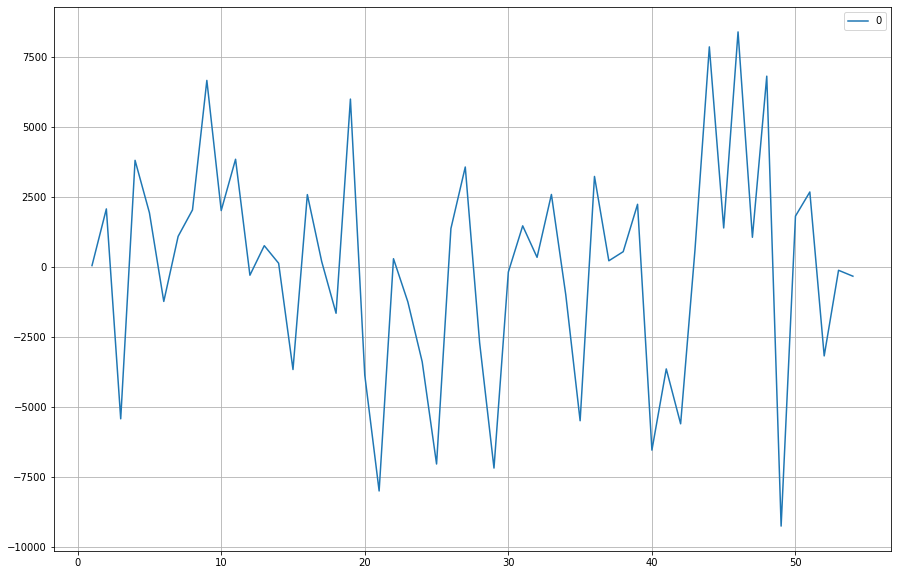

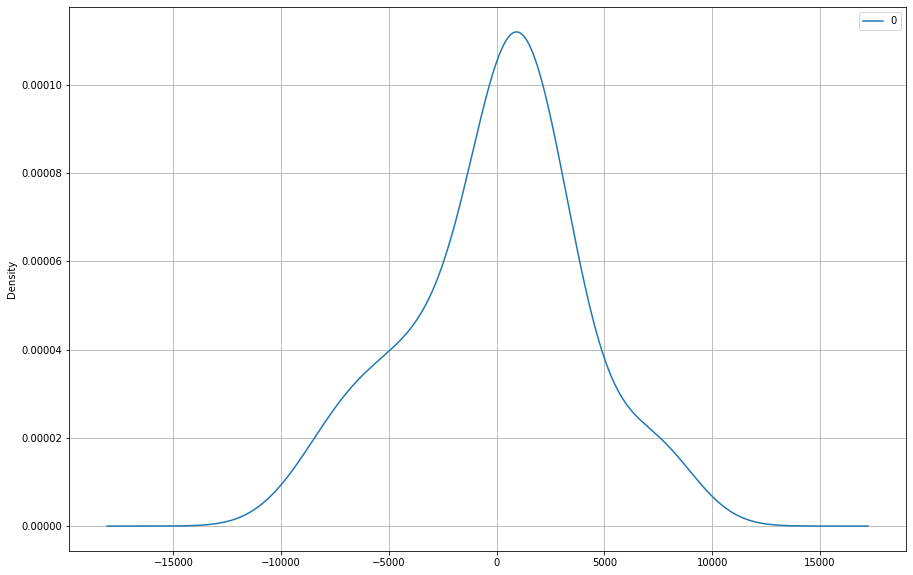

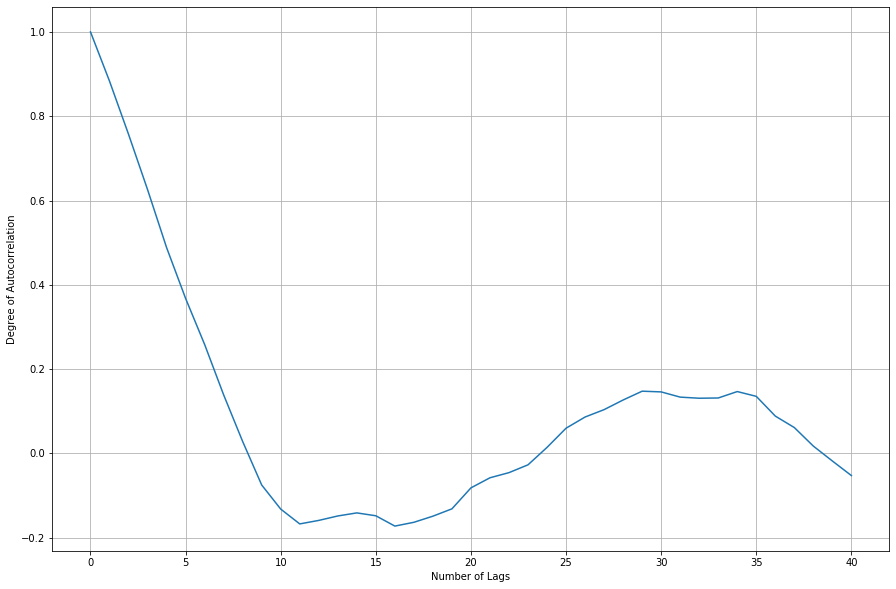

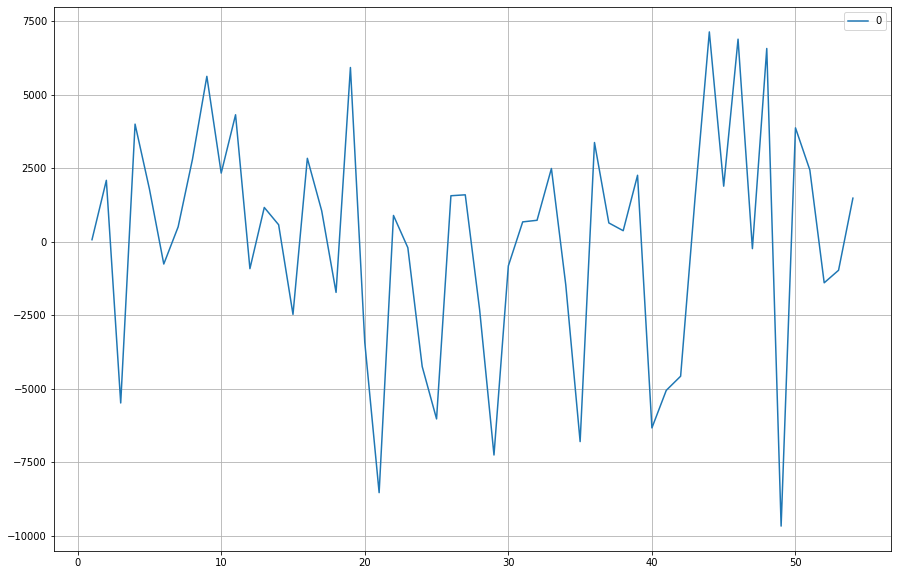

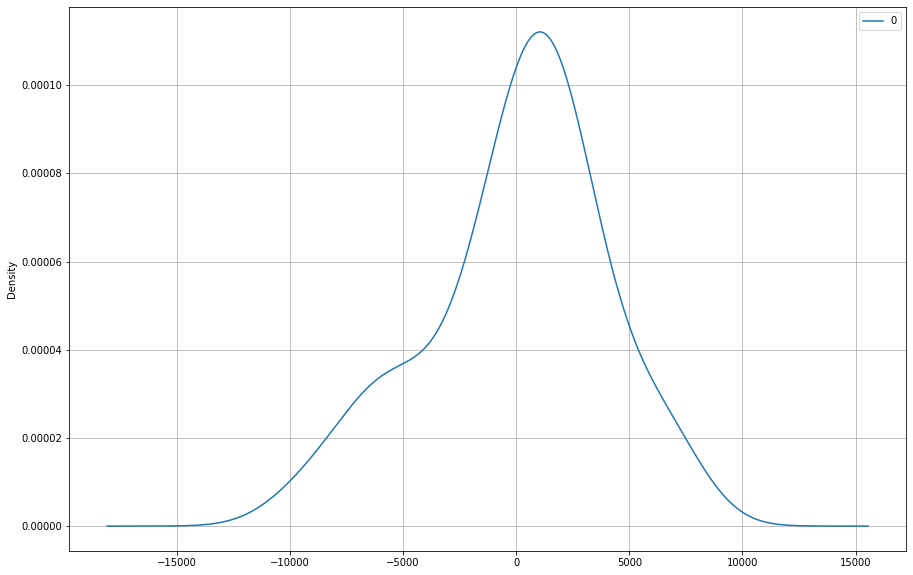

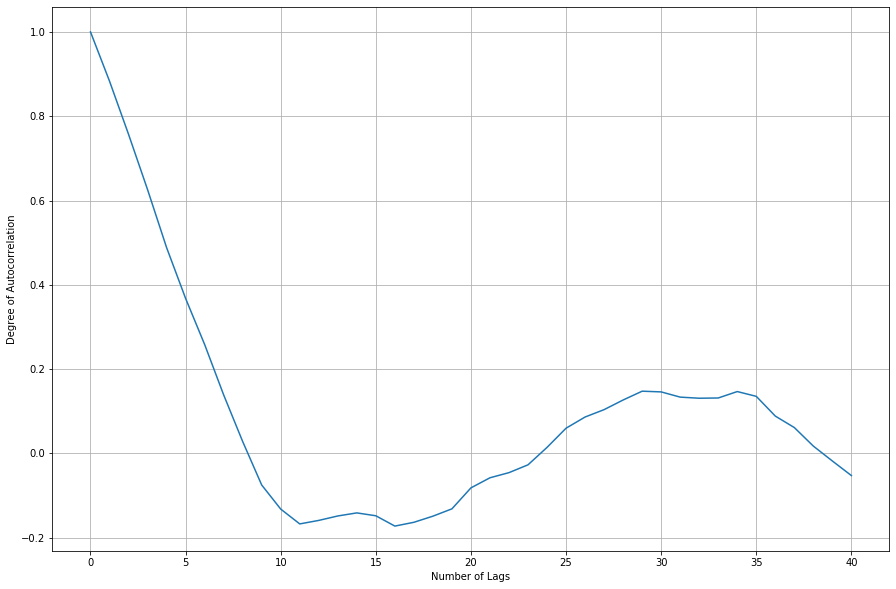

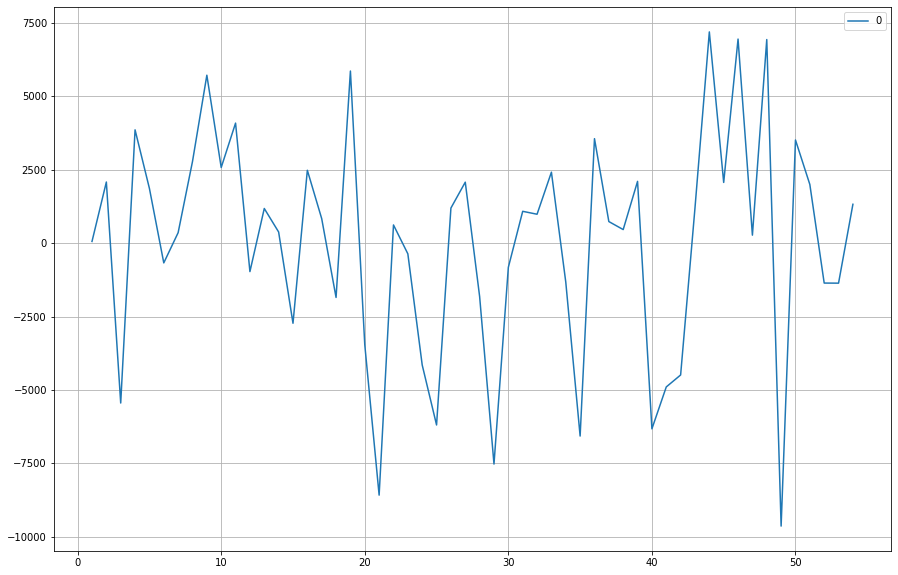

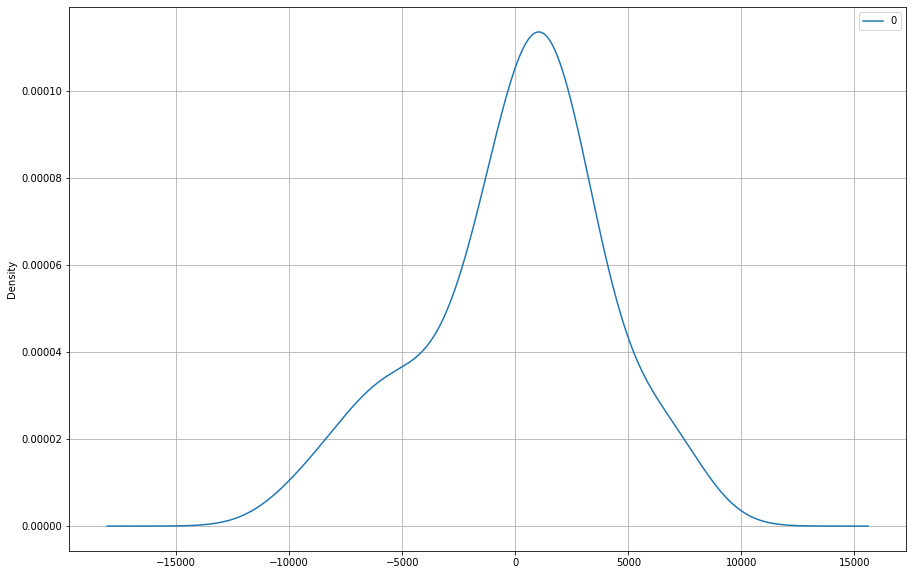

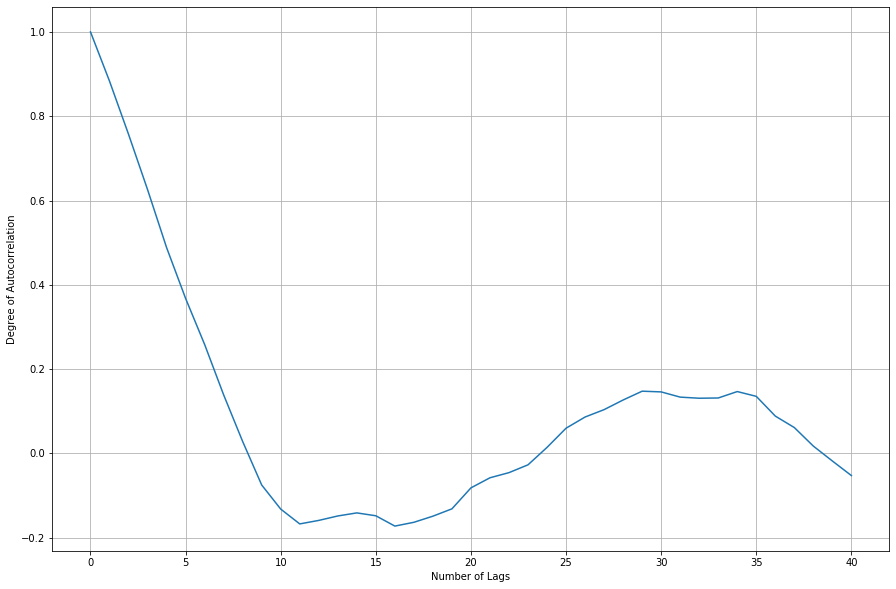

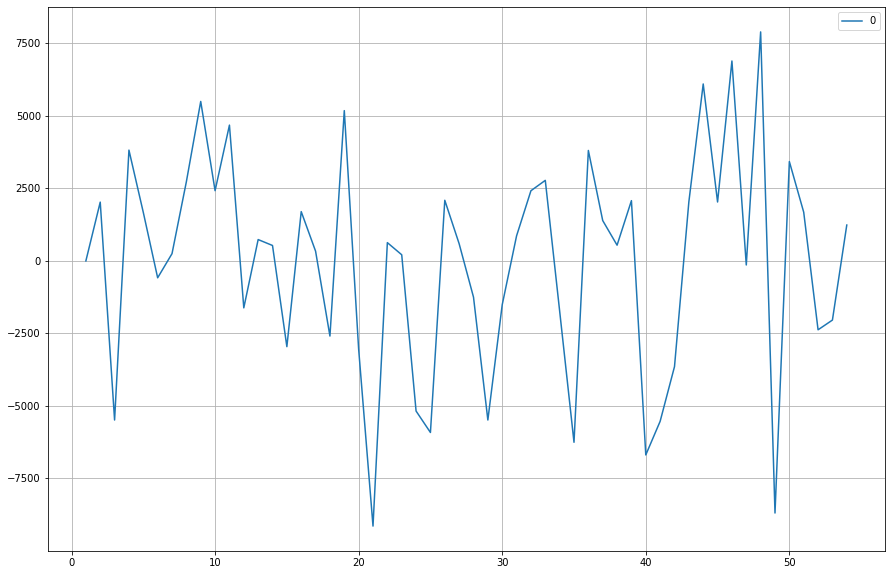

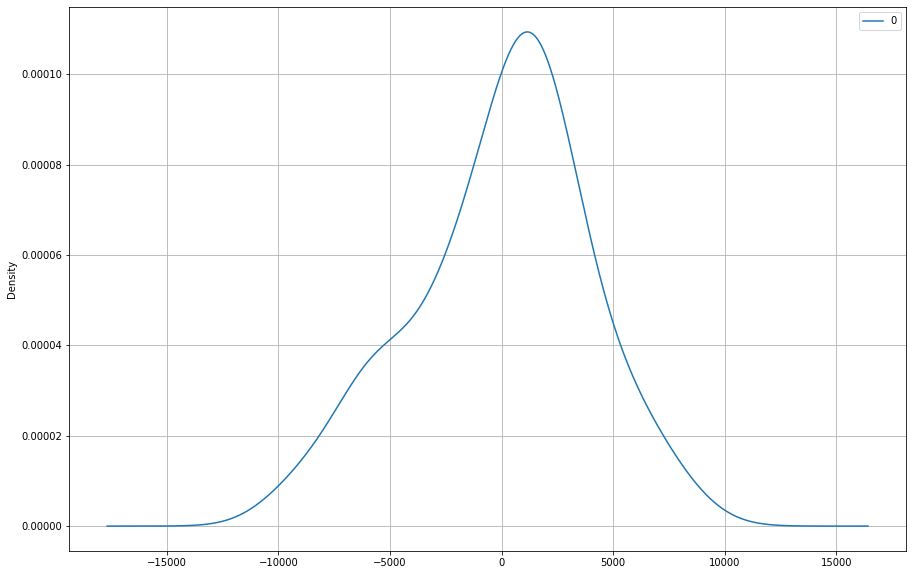

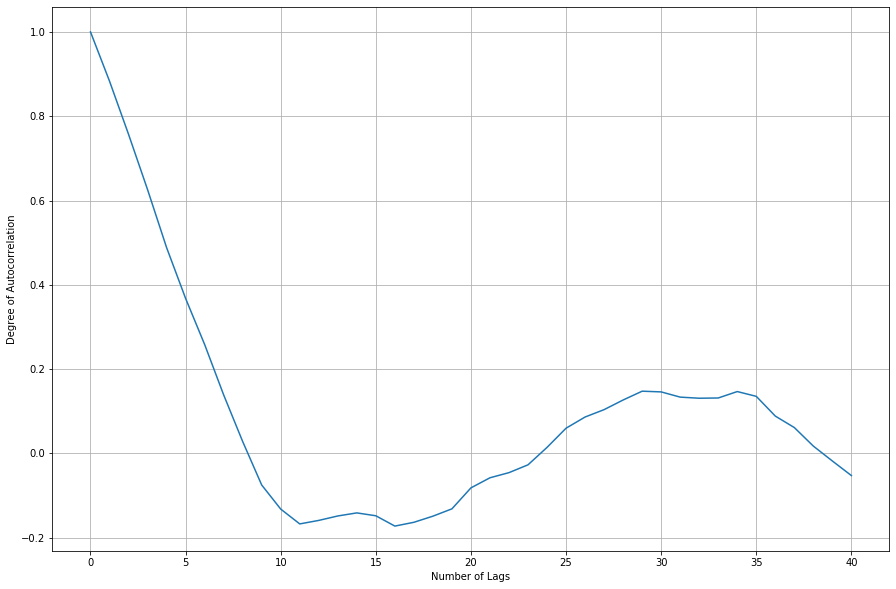

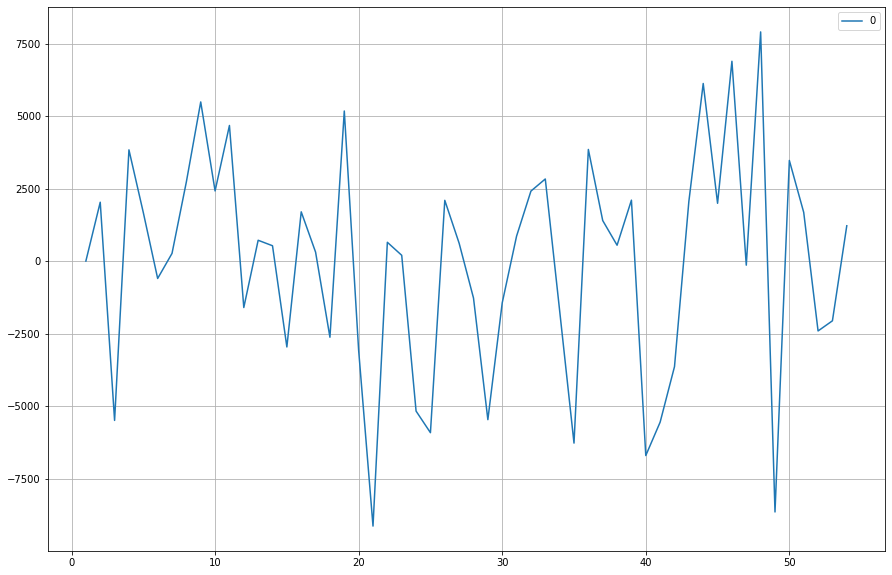

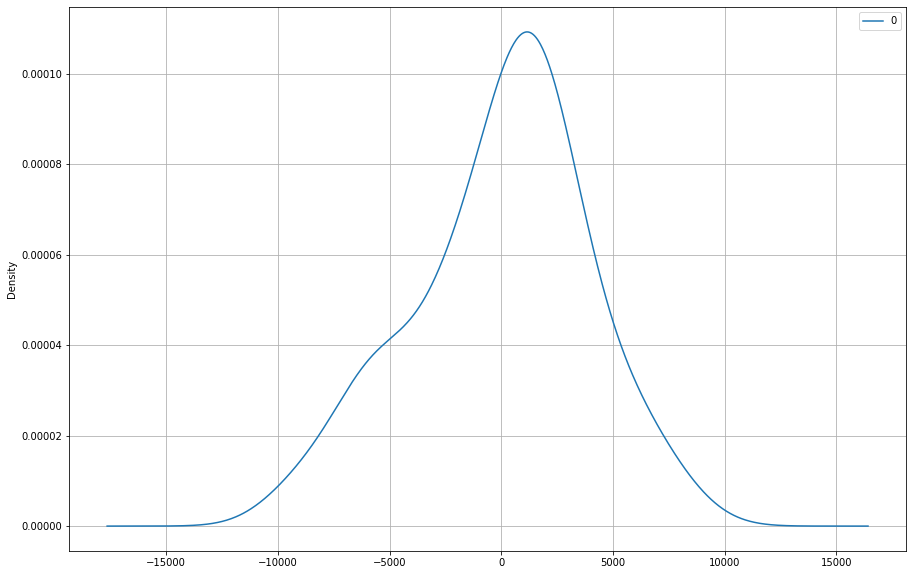

In [59]:
idx = 13
q = 0
d = 1
i = 0
vv = True
while vv ==  True and i <10:
	#data = data_scaled[0:n_years].iloc[:,idx]
	data = data_final[0:n_years].iloc[:,idx]
	try:
		p = np.where(acf(data)>0.9)[0][-1]
		
		#Plot Autocorrelation function
		plt.figure(figsize = (15,10))
		plt.xlabel("Number of Lags")
		plt.ylabel("Degree of Autocorrelation")
		plt.plot(acf(data))
		plt.grid()
		plt.show()
		
		#Fit Arima model with given order parameters
		model= ARIMA(data, (p,d,q))
		model_fit = model.fit(disp = 0, const = 'ctt')
	
		#Plot residual trend
		residuals = pd.DataFrame(pd.Series(model_fit.resid))
		residuals.plot(figsize = (15,10), grid = True)
		plt.show()

		#Plot residual distribution
		residuals.plot(kind='kde',figsize = (15,10), grid = True)
		plt.show()
		adfuller(series)[0]
		vv = False
	except: 
		if (d < 1):
			d += 1
		else:
			q +=1
	i += 1

In [60]:
order = (p,d,q)

In [61]:
series = data_final[0:n_years].iloc[:,idx]
ex = data_final[0:n_years].iloc[:,1]
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]

trainexog, testexog = ex[0:size], ex[size:len(ex)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=order)
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	observation = test[t]
	history.append(observation)

VISUALIZE PREDICTIONS

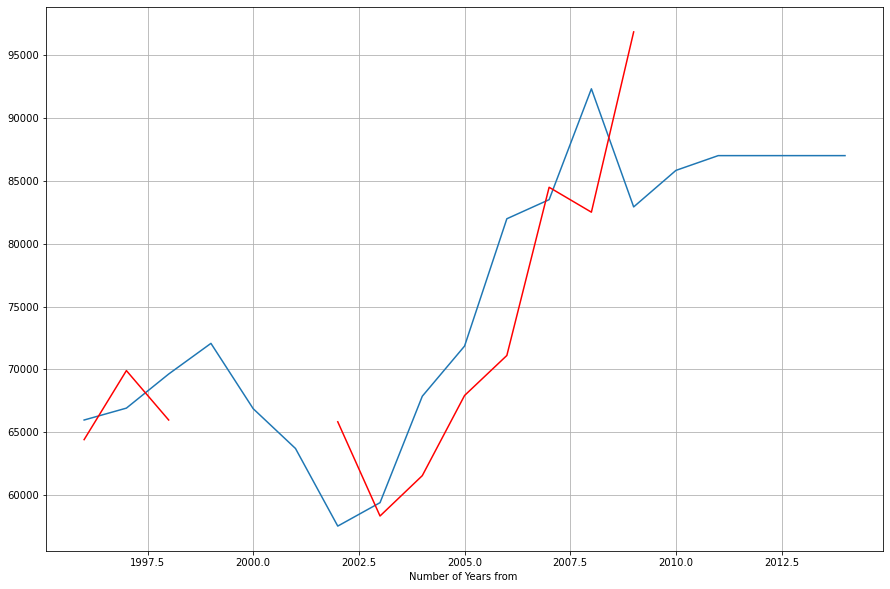

In [59]:
plt.figure(figsize = (15,10))
plt.xlabel("Number of Years from ")
plt.plot(range(1960+len(train),2015),test)
plt.plot(range(1960+len(train),2015),predictions, color='red')
plt.grid()

QUANTIFY PERFORMANCE

In [62]:
mse = np.mean(np.abs(np.array(test) -  np.array(predictions)))
mape = np.mean(np.abs((np.array(test) -  np.array(predictions))/np.array(predictions)))
print(f'Test MSE:{round(mse,2)} MSE')
print(f'Test MSE:{round(mape*100,2)}% MAPE')

Test MSE:nan MSE
Test MSE:nan% MAPE


In [63]:
data_final.index = processed_attributes.index
data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])]

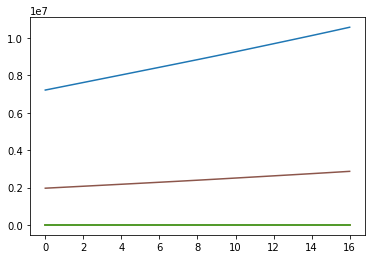

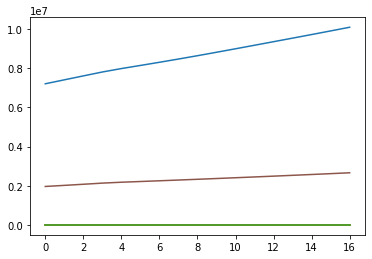

In [64]:
data_final.index = processed_attributes.index
data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['FRA'])]
sel_cols = np.where(data_final_country.columns.map(lambda x: x in influential))
data_final_country = data_final_country.iloc[:,sel_cols[0]]
data_final_country1 = np.abs(data_final_country.corr())>0.2
data_final_country1 = data_final_country1.applymap(makena)
data_final_country1.dropna(thresh = 10, axis=1, inplace=True)
dd = data_final_country[data_final_country1.columns]
n_years = data_final_country.shape[0]

dd = np.array(dd.iloc[:,7:20]).reshape(n_years,dd.iloc[:,7:20].shape[1])
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(dd))
scaler.inverse_transform(data_scaled)
vunscaled = dd[int(0.3*(len(dd))):]

#creating the train and validation set
train = dd[:int(0.7*(len(dd)))]
valid = dd[int(0.7*(len(dd))):]

#fit the model
model = VAR(endog=train)
model.select_order
model_fit = model.fit(maxlags = 30, trend = 'ctt')

# make prediction on validation
prediction = model_fit.forecast(model_fit.y,steps=len(valid))
plt.plot(prediction)
plt.show()
plt.plot(np.array(valid))
plt.show()

In [65]:
pred_df = pd.DataFrame(prediction)
valid_df =  pd.DataFrame(valid).reset_index().drop('index',1) #index columns did not match
np.mean((np.abs(pred_df - valid_df)/np.abs(valid_df)).mean(1))

0.10236294548971696

### SVM 

In [66]:
# todo moses: description, docstrings, references, plot labels

In [67]:
columns = ['SP.POP.0014.TO.ZS','SP.POP.DPND.YG','SP.POP.DPND','SP.POP.TOTL','SP.RUR.TOTL','SP.RUR.TOTL.ZS','SP.POP.TOTL.FE.ZS','PA.NUS.ATLS','SP.POP.GROW']
data_interest = pd.DataFrame(data_final, columns=columns)


data_argentina = data_interest.iloc[:,] 
data_arg = data_argentina[0:54]
data_arg_train = data_arg[['SP.POP.0014.TO.ZS','SP.POP.TOTL','SP.RUR.TOTL']]

year_argentina = list(map(lambda x: x[1], data_arg_train.index))
feature_arg = data_arg['SP.POP.0014.TO.ZS'].values


In [68]:
X = np.asmatrix(year_argentina).reshape(-1,1)
Y = np.asmatrix(feature_arg).reshape(-1,1)
X_train = X[0:35]
X_test = X[36:]
y_train = Y[0:35]
y_test = Y[36:]


In [69]:
svr_model = SVR(kernel= 'rbf', C= 1000, epsilon = 0.05, gamma= 0.001)
svr_model.fit(X_train,y_train)
y_pred = svr_model.predict(X_test)


### SVR Optimization

In [70]:
gsc = GridSearchCV(estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv = 5, scoring='neg_mean_squared_error', verbose=0)

grid_result = gsc.fit(X, Y)
best_params = grid_result.best_params_


In [71]:
best_svr = SVR(kernel='rbf', C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"],
                   coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)
best_svr.fit(X_train,y_train)
y_pred = best_svr.predict(X_test)


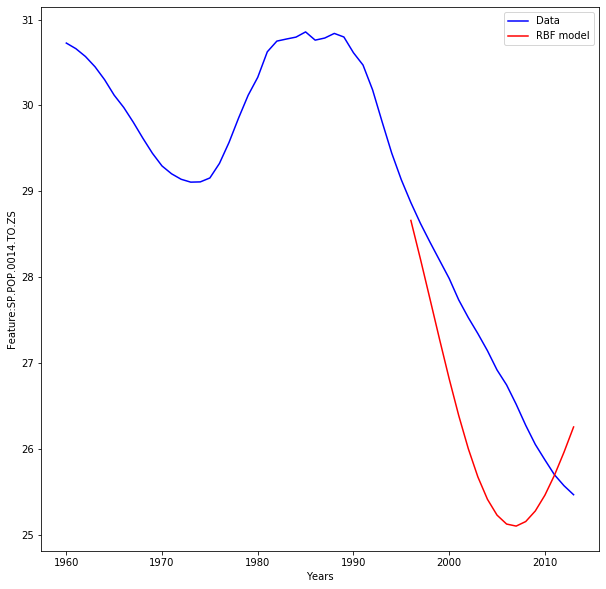

In [72]:
plt.figure(figsize = (10,10))
plt.plot(X, Y, color= 'blue', label= 'Data')
plt.plot(X_test,y_pred, color= 'red', label= 'RBF model') 
plt.xlabel('Years')
plt.ylabel('Feature:SP.POP.0014.TO.ZS')
plt.legend()
plt.show()

### Mean Squared Error for SVR

In [73]:
mse = mean_squared_error(y_test,y_pred)
mse

1.2827828962641137

### Mean Absolute Error for SVR

In [74]:
mae = mean_absolute_error(y_test,y_pred)
mae

0.9928602899819542

### LSTM 

In [75]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # Generates batches for sequence data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [76]:
df = pd.DataFrame(data = feature_arg,index = year_argentina,columns=['SP.POP.0014.TO.ZS'])

len(df) 
test_pecent = 0.9 
len(df)*test_pecent 
test_point = np.round(len(df)*test_pecent) 
test_index = int(len(df) - test_point) 
train = df.iloc[:test_index]
test = df.iloc[test_index:]


In [77]:
scaler = MinMaxScaler()
scaler.fit(train)
MinMaxScaler(copy=True, feature_range=(0, 1))
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)
#len(scaled_train) 
#len(generator) 

In [78]:
n_features = 1
early_stop = EarlyStopping(monitor='val_loss',patience=2)
length = 1
batch_size = 1

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=batch_size)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=length,batch_size=batch_size)

model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer = 'adam',loss='mae',metrics=['accuracy'])

model.fit_generator(generator,epochs=2,validation_data=validation_generator,callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
4/4 [==============================] - 1s 152ms/step - loss: 0.4768 - accuracy: 0.2500 - val_loss: 3.8266 - val_accuracy: 0.0000e+00
Epoch 2/2
4/4 [==============================] - 0s 23ms/step - loss: 0.4738 - accuracy: 0.2500 - val_loss: 3.8084 - val_accuracy: 0.0000e+00


In [79]:
test_predictions = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]

  test_predictions.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

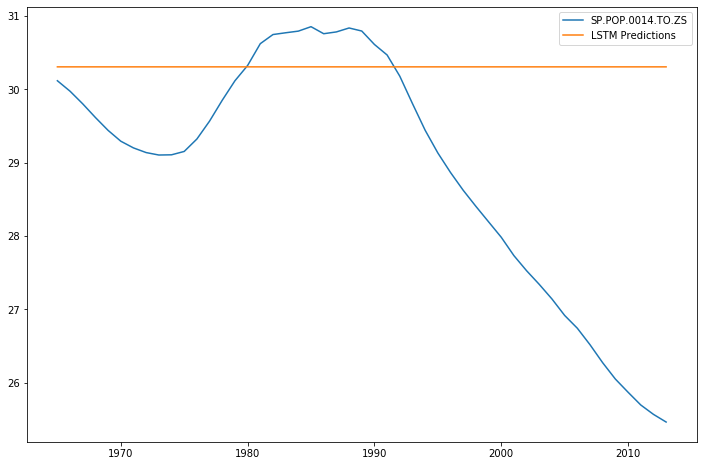

In [80]:
true_predictions = scaler.inverse_transform(test_predictions)
test['LSTM Predictions'] = true_predictions
test.plot(figsize=(12,8))

### Forcast for full Data

In [81]:
full_scaler = MinMaxScaler()

scaled_full_data = full_scaler.fit_transform(df)

generator = TimeseriesGenerator(scaled_full_data,scaled_full_data,length=length,batch_size=batch_size)

model = Sequential()

model.add(LSTM(50,input_shape=(length,n_features)))
#model.add(Dropout(0.3))

model.add(Dense(1))

model.compile(optimizer = 'adam',loss='mae',metrics=['accuracy'])

model.fit_generator(generator = generator, epochs=0)

In [82]:
forecast = []

first_eval_batch = scaled_train[-length:]

current_batch = first_eval_batch.reshape(1,length,n_features)


for i in range(60):
  current_pred = model.predict(current_batch)[0]

  forecast.append(current_pred)

  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis = 1)

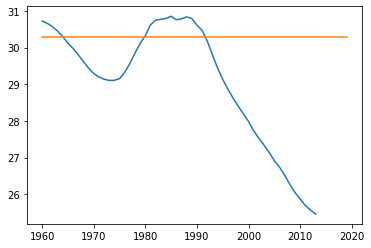

In [83]:
forecast = scaler.inverse_transform(forecast)

forecast_index = np.arange(1960,2020,step = 1)

plt.plot(df.index,df['SP.POP.0014.TO.ZS'])
plt.plot(forecast_index,forecast)

## Time series forcast using random forest

In [84]:
# todo yosief: description, docstrings, plot labels, 

In this section, we are using the Random Forest regressor for time series forecasting. We will be using a time series with single indicator, the indicator is from the country USA and the indicator name is Population ages 15-64 (% of total population).




-> actual=60.6, -> predicted=59.8
-> actual=60.8, -> predicted=60.3
-> actual=60.9, -> predicted=60.6
-> actual=61.0, -> predicted=60.8
-> actual=61.0, -> predicted=60.9
-> actual=61.2, -> predicted=61.0
-> actual=61.3, -> predicted=61.1
-> actual=61.6, -> predicted=61.2
-> actual=62.1, -> predicted=61.5
-> actual=62.5, -> predicted=61.8
-> actual=62.9, -> predicted=62.3
-> actual=63.2, -> predicted=62.6
-> actual=63.4, -> predicted=63.0
-> actual=63.5, -> predicted=63.3
-> actual=63.7, -> predicted=63.4
-> actual=64.0, -> predicted=63.6
-> actual=64.2, -> predicted=63.9
-> actual=64.6, -> predicted=64.1
-> actual=65.0, -> predicted=64.4
-> actual=65.4, -> predicted=64.8
MAE: 0.426
MAPE: 0.678
MSE: 0.218


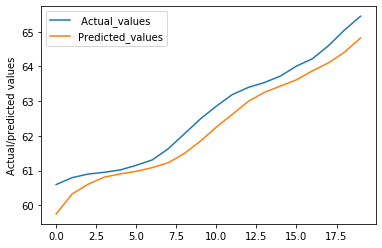

In [85]:

def timeseries_supervised(value, input_steps=1, out_steps=1, dropnan=True):
    '''
     creates  a supervised learning dataset by using previous time steps as input variables
     and use the next time step as the output variable.
     
     returns a two dimensional array
    '''
    
    df = DataFrame(value)
    columns = [] 
    #put input sequence to a list
    for i in range(input_steps, 0, -1):
        columns.append(df.shift(i))  
    # put forcast sequence to alist
    for i in range(0, out_steps):
        columns.append(df.shift(-i))    
    concatnate = concat(columns, axis=1)
    # drop rows with NaN values
    if dropnan:
        concatnate.dropna(inplace=True)
    return concatnate.values
 

def split_train_test(data, test_num):
    '''
    splits and returns dataset into train/test sets
    '''
    return data[:-test_num, :], data[-test_num:, :]
 

def random_forest_forecast(train, testX):
    '''
     one step prediction by fiting a random forest model 
     returns predicted value
    '''
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]
 

def walk_forward_validation(data, n_test):
    '''    
      Splits the dataset into train and test, in order to make a one-step forcast, we evaluate
      the model by training on the training dataset and predicting the first step in the test dataset.
      We can then add the real observation from the test set to the training dataset,
      refit the model, then have the model predict the second step in the test dataset.
     
      returns  mae,mape,mse, actual value, predictions value
    '''
    predictions = list()
    # split dataset
    train, test = split_train_test(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = random_forest_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('-> actual=%.1f, -> predicted=%.1f' % (testy, yhat))
        # estimate prediction error
    mape=np.mean(np.abs((test[:, -1] - predictions) / test[:, -1])) * 100
    mse=mean_squared_error(test[:, -1], predictions)
    mae = mean_absolute_error(test[:, -1], predictions)
    return mae,mape,mse, test[:, -1], predictions
    
 
# load the dataset
data_final.index = processed_attributes.index
data_USA=data_final.loc['USA']
ts = pd.Series(data_USA['SP.POP.1564.TO.ZS'].values, index=data_USA.index)
df = pd.DataFrame({'time':ts.index, 'measure':ts.values})
df_time=df.set_index('time')
values = df_time.values

data = timeseries_supervised(values, 10,1)

# evaluate
mae,mape,mse, y, yhat = walk_forward_validation(data, 20)
print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
print('MSE: %.3f' % mse)
# plot expected vs predicted
pyplot.plot(y, label=' Actual_values')
pyplot.plot(yhat, label='Predicted_values')
pyplot.ylabel('Actual/predicted values')
pyplot.legend()
pyplot.show()

source: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [86]:
def get_indicator_name(indicator_code, country_code, year):
    '''
    Returns indicator name from provided indicator code, country code and year
    :params: todo: indicator_code
    :params: todo: country_code
    :params: todo: year
    
    '''
    indicator_code_filter = indicators_df['IndicatorCode'] == indicator_code
    country_code_filter = indicators_df['CountryCode'] == country_code
    year_filter = indicators_df['Year'] == year

    return indicators_df[
        indicator_code_filter &
        country_code_filter &
        year_filter
    ][['IndicatorName']].values[0][0]

In [87]:
indicator_code = 'EN.ATM.CO2E.LF.KT'
get_indicator_name('EN.ATM.CO2E.LF.KT', 'USA', 2008) # any year containing the indicator is good for our function

'CO2 emissions from liquid fuel consumption (kt)'

### Selecting data

In [88]:
# put index to data_final if it does not exist
data_final.index = processed_attributes.index

In [89]:
train_ratio = 0.8

data_final_country = data_final[np.in1d(data_final.index.get_level_values(0), ['USA'])][[indicator_code]].reset_index(level=0,drop=True)

train_cutoff = int(len(data_final_country[[indicator_code]]) * train_ratio)

data_final_country_train = data_final_country[[indicator_code]][:train_cutoff]
data_final_country_test = data_final_country[[indicator_code]][train_cutoff:]

### Testing stationarity

#### Types of Stationarity

Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.

Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.

Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.



### Average Dickey-Fuller test (ADF)

In [90]:
ts = data_final_country

result = adfuller(ts)
print('ADF statistic : %f' % result[0])
# the 0 element is the test statistics, 
#the more negative it is the more likely that the data is stationary

print('p-Value: %f'%result[1])
print('critical values:')
#the 1 element is the p_value 
#if p-value is small, reject the H0. Reject non-stationary

for key, value in result [4].items():
    print('\t%s: %.3f' % (key, value))
#the 4th element is the critical test statistics,
# our test statistic needs to be below the critical value to get less than the p-value

if result[0] < result[4]['5%']:
    print ('Reject Hypothesis 0 - Time series is stationary')
else :
    print ('Failed to reject the null hypothesis _ Time series is Non-Stationary')

ADF statistic : -1.588041
p-Value: 0.489598
critical values:
	1%: -3.560
	5%: -2.918
	10%: -2.597
Failed to reject the null hypothesis _ Time series is Non-Stationary


References:

Dickey-Fuller test for Time Series Stationarity using Python: https://www.youtube.com/watch?v=warCSvy1DMk&ab_channel=BhaveshBhatt

Python Tutorial: Making time series stationary: https://www.youtube.com/watch?v=bP1fbXd_XSk&ab_channel=DataCamp

### Testing trend stationarity

In [91]:
# It’s better to apply both tests (ADF and KPSS) to be sure that the series is truly stationary.

from statsmodels.tsa.stattools import kpss

# kpss test function
def kpss_test(ts):
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c',nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
     
    return kpss_output
    
kpss = kpss_test(ts)
print(kpss)

#kpss['Test Statistic']

#Test for stationarity: If the test statistic is greater than the critical value, 
#we reject the null hypothesis (series is not trend stationary).
if kpss ['Test Statistic'] < kpss ['Critical Value (5%)']:
    print ('Failed to reject the null hypothesis _ Time series is Non-(trend) Stationary') 
else :
    print ('Reject Hypothesis 0 - Time series is (trend) stationary')

Results of KPSS Test:
Test Statistic           0.783744
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Reject Hypothesis 0 - Time series is (trend) stationary


#### Checking which stationarity type is our time series from comparing both tests outcomes

Case 1: Both tests conclude that the series is not stationary -> series is not stationary

Case 2: Both tests conclude that the series is stationary -> series is stationary

Case 3: KPSS = stationary and ADF = not stationary -> trend stationary, remove the trend to make series strict station ary

Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary


Reference :

A Gentle Introduction to Handling a Non-Stationary Time Series in Python: https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/ 

In [92]:
kpss

Test Statistic           0.783744
p-value                  0.010000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

In [93]:
# Case 1
if kpss ['Test Statistic'] < kpss ['Critical Value (5%)'] and result [0] > result [4]['5%']:
    print('The series is not stationary')

# Case 2
if kpss ['Test Statistic'] > kpss ['Critical Value (5%)'] and result [0] < result [4]['5%']:
    print('The series is stationary')

# Case 3
if kpss ['Test Statistic'] > kpss ['Critical Value (5%)'] and result [0] > result [4]['5%']:
    print('the series is Trend stationary, remove the trend to make series strict stationary')
    
# Case 4
if kpss ['Test Statistic'] < kpss ['Critical Value (5%)'] and result [0] < result [4]['5%']:
    print('Use differencing to make series stationary')


the series is Trend stationary, remove the trend to make series strict stationary


### ARIMA parameters : p , d and q

<b>p:</b> The number of lag observations included in the model, also called the lag order.

<b>d:</b> The number of times that the raw observations are differenced, also called the degree of differencing.

<b>q:</b> The size of the moving average window, also called the order of moving average.



Reference:

Autoregressive Integrated Moving Average (ARIMA): https://www.investopedia.com/terms/a/autoregressive-integrated-moving-average-arima.asp

### Searching for "d"

In [94]:
# todo: fix error by using .loc
# one way to make the ts stationary is to take the difference
data_final_country[f'{indicator_code}_diff_1'] = data_final_country[[indicator_code]].diff() # first differenciation
data_final_country[f'{indicator_code}_diff_2'] = data_final_country[[f'{indicator_code}_diff_1']].diff() # second differenciation
data_final_country[f'{indicator_code}_diff_3'] = data_final_country[[f'{indicator_code}_diff_2']].diff() # 3rd differenciation

# print(
#     data_final_country[f'{indicator_code}_diff_1'], 
#     data_final_country[f'{indicator_code}_diff_2'],
#     data_final_country[f'{indicator_code}_diff_3'],
#     sep='\n'
# )

In [95]:
diff_values_country_1 = data_final_country[f'{indicator_code}_diff_1'].values
diff_values_country_2 = data_final_country[f'{indicator_code}_diff_2'].values
diff_values_country_3 = data_final_country[f'{indicator_code}_diff_3'].values
# print(
#     diff_values_country_1,
#     diff_values_country_2,
#     diff_values_country_3,
#     sep='\n'
# )
Y_0 = data_final_country[indicator_code].values
Y_1 = diff_values_country_1[~np.isnan(diff_values_country_1)]
Y_2 = diff_values_country_2[~np.isnan(diff_values_country_2)]
Y_3 = diff_values_country_3[~np.isnan(diff_values_country_3)]
# print(
#     len(Y_0), Y_0,
#     len(Y_1), Y_1,
#     len(Y_2), Y_2,
#     len(Y_3), Y_3,
#     sep='\n'
# )
ts_values_1 = Y_0[:-1]
ts_values_2 = Y_1[:-1]
ts_values_3 = Y_2[:-1]
# print(len(ts_values_1), ts_values_1)
# print(len(ts_values_2), ts_values_2)
# print(len(ts_values_3), ts_values_3)
X_1 = sm.add_constant(ts_values_1)
X_2 = sm.add_constant(ts_values_2)
X_3 = sm.add_constant(ts_values_3)
model_1 = sm.OLS(Y_1, X_1)
model_2 = sm.OLS(Y_2, X_2)
model_3 = sm.OLS(Y_3, X_3)
results_1 = model_1.fit()
results_2 = model_2.fit()
results_3 = model_3.fit()

In [96]:
print(results_1.summary())
print('..................................................................')
print(results_2.summary())
# print('..................................................................')
# print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     4.270
Date:                Mon, 07 Dec 2020   Prob (F-statistic):             0.0438
Time:                        02:54:05   Log-Likelihood:                -561.98
No. Observations:                  54   AIC:                             1128.
Df Residuals:                      52   BIC:                             1132.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6378.8525   2831.475      2.253      0.0

In [97]:
#if t-value is smaller than critical value une the number of the differenciation as the d value for ARIMA function
print(results_1.tvalues[1]) 
print(results_2.tvalues[1]) 
print(results_3.tvalues[1]) 

-2.0663378345405143
-9.820778033841432
-13.81947331499778


In [98]:
adfuller_0 = adfuller(Y_0)
adfuller_1 = adfuller(Y_1)
adfuller_2 = adfuller(Y_2)

print(
    adfuller_0,
    adfuller_1,
    adfuller_2,
    sep='\n'
)

(-1.588041222651278, 0.4895979832147209, 1, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 905.8295366183261)
(-9.82077803384143, 5.345456655698241e-17, 0, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 886.5795228986448)
(-6.622432935662094, 5.9903210421245416e-09, 4, 48, {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}, 874.7980963937174)


### Finding p and q through ACF and PACF plots

![ACF%20and%20PACF%20reading.png](attachment:ACF%20and%20PACF%20reading.png)

source: https://www.linkedin.com/pulse/reading-acf-pacf-plots-missing-manual-cheatsheet-saqib-ali?fbclid=IwAR2FbMaWr0uurgKgTiqSIDHgn4FhuP6h0Q7VM25tL0C5a1HD6A15plbkOF8

In [99]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

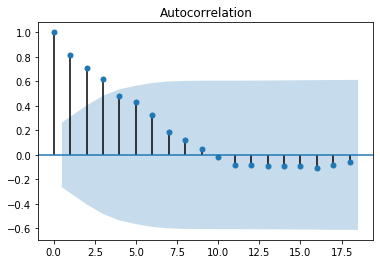

In [100]:
plot_acf(Y_0)
pyplot.show()

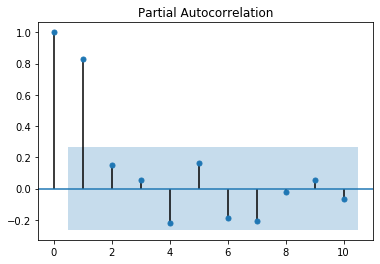

In [101]:
plot_pacf(Y_0, lags=10)
pyplot.show()

TODO: Describe how we figured out the p and q parameters.

### ARIMA

In [102]:
from scipy import stats
from scipy.stats import normaltest

In [103]:
# arima_model = ARIMA(data_final_country[[indicator_code]], (2,2,0)).fit()
arima_model = ARIMA(data_final_country_train, (2,2,0)).fit()
print(arima_model.summary())

                              ARIMA Model Results                               
Dep. Variable:     D2.EN.ATM.CO2E.LF.KT   No. Observations:                   42
Model:                   ARIMA(2, 2, 0)   Log Likelihood                -430.638
Method:                         css-mle   S.D. of innovations           6808.413
Date:                  Mon, 07 Dec 2020   AIC                            869.276
Time:                          02:54:20   BIC                            876.227
Sample:                               2   HQIC                           871.824
                                                                                
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        108.3325    497.810      0.218      0.828    -867.358    1084.023
ar.L1.D2.EN.ATM.CO2E.LF.KT    -0.7163      0.157     -4.559      0.

NormaltestResult(statistic=2.390145413898275, pvalue=0.3026819463012149)


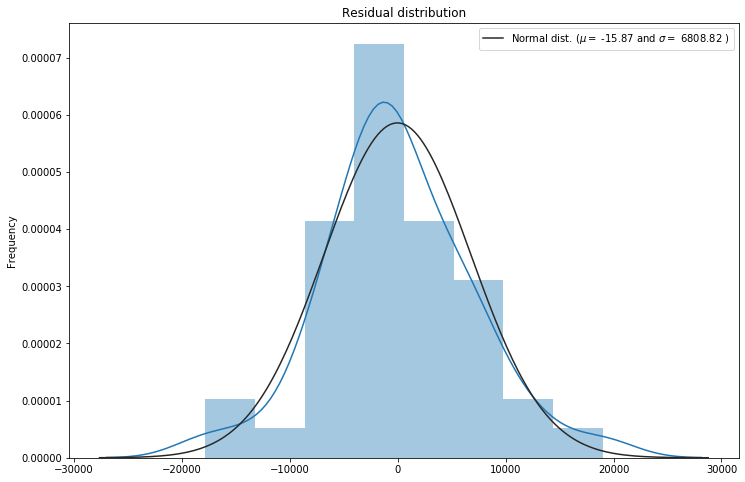

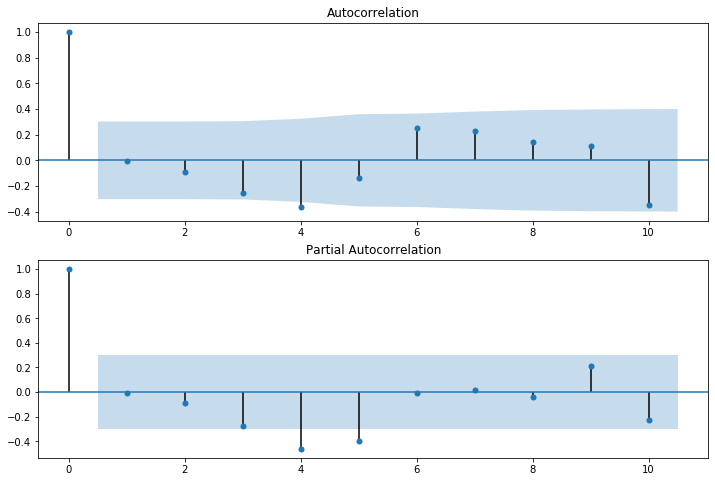

In [104]:
resid = arima_model.resid
# print(resid)
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_model.resid, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_model.resid, lags=10, ax=ax2)

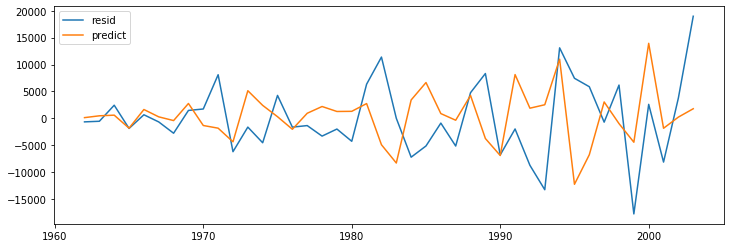

In [105]:
# start_index = 0 # todo: find out why 5? is it a lag?
# end_index = 45

Y_0_df = pd.DataFrame(arima_model.resid, columns=['resid']) # , index=data_final_country.index.get_level_values(1))
Y_0_df['predict'] = None

Y_0_df.loc[:,('predict')] = arima_model.predict()


# Y_0_df.loc[data_final_country_train.index.max():,('forecast')] = 10
# Y_0_df['value'] = data_final_country[[indicator_code]]
Y_0_df[['resid', 'predict']].plot(figsize=(12, 4))

#arima_model.forecast(11)[0]
#Y_0_df

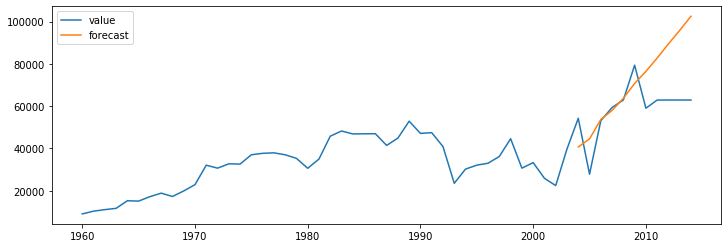

In [106]:
xxx = pd.DataFrame(data_final_country[[indicator_code]].values, columns=['value'], index=data_final_country.index)
xxx['forecast'] = None

xxx.loc[data_final_country_test.index.min():,('forecast')] = arima_model.forecast(data_final_country_test.shape[0])[0]

xxx[['value', 'forecast']].plot(figsize=(12, 4))

#### Error testing

Test MSE: 6255.417
Test MAPE: 3.564


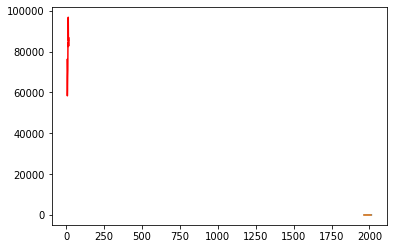

In [107]:
mse = np.mean(np.abs(np.array(Y_0_df[['resid']]) -  np.array(Y_0_df[['predict']])))
mape = np.mean(np.abs((np.array(Y_0_df[['resid']]) -  np.array(Y_0_df[['predict']]))/np.array(Y_0_df[['predict']])))
print('Test MSE: %.3f' % mse)
print('Test MAPE: %.3f' % mape)
plt.plot(test)
plt.plot(predictions, color='red')